# Airline Arrivals Project
Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.
1.	The project should follow guideline as previous projects.
2.	Apply models in Naïve Bayes, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting and XGBoost.
3.	Apply PCA, SelectKBest and RFE for feature selections.
4.	Using gridsearchCV to obtain best parameters for models.
5.	Compare performances among models, write up analysis why the model is good or bad in the algorithmic approach (explain why the algorithm is good or bad for the dataset structure, can you do something to improve the model?)
6.	Include the conclusions.


In [ ]:
# Install Java, Spark
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
#Download xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j/0.72/xgboost4j-0.72.jar
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j-spark/0.72/xgboost4j-spark-0.72.jar
#Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/xgboost4j-spark-0.72.jar,/content/xgboost4j-0.72.jar pyspark-shell'

import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [748 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports In

In [ ]:
#Mount to Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
#Shorten the link (optional)
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd '/content/gdrive/MyDrive/CBD_Robotics_Training/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/CBD_Robotics_Training


In [ ]:
#Install squarify
!pip install squarify

In [ ]:
#Install xgboost
!pip install xgboost

In [ ]:
#Install joblibspark
!pip install joblibspark

In [ ]:
#Import necessary libraries in scikit-learn ML
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import squarify as sq

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import sparse
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [ ]:
#Import necessary libraries in Spark ML
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType, StructField, StructType, IntegerType, FloatType
from pyspark.sql.functions import isnan, when, count, col, length

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, IDF, StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import NaiveBayesModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import GBTClassificationModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
#Create Spark Context
SparkContext.setSystemProperty('spark.executor.memory', '6g')
sc = SparkContext(master='local', appName='Airline_Arrivals_Project')

In [ ]:
#Create Spark Session
spark = SparkSession(sc)

In [ ]:
#Add the PySpark XGBoost package into Spark
spark.sparkContext.addPyFile("Pyspark_xgboost/sparkxgb.zip")

In [ ]:
#Import PySpark XGBoost functions into Spark
from sparkxgb import XGBoostEstimator, XGBoostClassificationModel, XGBoostRegressionModel

## Data Preparation

In [ ]:
#Load dataset '2008'
data = pd.read_csv('dataset/2008.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389217 entries, 0 to 2389216
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [ ]:
#Display the first 5 rows
data.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1343.0,1325,1451.0,1435,WN,588,N240WN,68.0,70.0,55.0,16.0,18.0,HOU,LIT,393,4.0,9.0,0,NaN,0,16.0,0.0,0.0,0.0,0.0
1,2008,1,3,4,1125.0,1120,1247.0,1245,WN,1343,N523SW,82.0,85.0,71.0,2.0,5.0,HOU,MAF,441,3.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,2009.0,2015,2136.0,2140,WN,3841,N280WN,87.0,85.0,71.0,-4.0,-6.0,HOU,MAF,441,2.0,14.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,903.0,855,1203.0,1205,WN,3,N308SA,120.0,130.0,108.0,-2.0,8.0,HOU,MCO,848,5.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1423.0,1400,1726.0,1710,WN,25,N462WN,123.0,130.0,107.0,16.0,23.0,HOU,MCO,848,6.0,10.0,0,NaN,0,16.0,0.0,0.0,0.0,0.0


In [ ]:
#Display the last 5 rows
data.tail(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2389212,2008,4,17,4,1025.0,1025,1234.0,1237,DL,1207,N393DA,129.0,132.0,108.0,-3.0,0.0,BOS,CVG,752,5.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2389213,2008,4,17,4,1319.0,1320,1527.0,1524,DL,1208,N952DL,128.0,124.0,107.0,3.0,-1.0,CVG,BOS,752,9.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2389214,2008,4,17,4,1335.0,1335,1556.0,1553,DL,1209,N392DA,141.0,138.0,103.0,3.0,0.0,BOS,CVG,752,7.0,31.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2389215,2008,4,17,4,1933.0,1935,2140.0,2141,DL,1210,N3756,127.0,126.0,106.0,-1.0,-2.0,CVG,BOS,752,9.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2389216,2008,4,17,4,621.0,615,752.0,754,DL,1211,N951DL,91.0,99.0,64.0,-2.0,6.0,BWI,CVG,430,15.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Check whether each column has any null values or not
data.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                64442
CRSDepTime                 0
ArrTime                70096
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                42452
ActualElapsedTime      70096
CRSElapsedTime           407
AirTime                70096
ArrDelay               70096
DepDelay               64442
Origin                     0
Dest                       0
Distance                   0
TaxiIn                 70096
TaxiOut                64442
Cancelled                  0
CancellationCode     2324775
Diverted                   0
CarrierDelay         1804634
WeatherDelay         1804634
NASDelay             1804634
SecurityDelay        1804634
LateAircraftDelay    1804634
dtype: int64

### Comments:
- We can see that there are many columns with a large number of null values.  
- Because our concern focuses on 'ArrDelay' feature, meaning this column must not be null. Therefore, we will start to remove all rows with null values in this column.
- Then, we will move on processing null values for other columns.

In [ ]:
#Check whether the dataset has any duplicated rows or not
print('Number of duplicated rows:', data.duplicated().sum())

Number of duplicated rows: 4


In [ ]:
#Make another copy of movies dataset for data processing and exploration, and keep the original dataset intact
flights = data.copy(deep=True)

In [ ]:
#Data preprocessing - Remove duplicated rows
flights = flights.drop_duplicates().reset_index().drop('index', axis = 1)
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389213 entries, 0 to 2389212
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [ ]:
#Because we focus on 'ArrDelay', this column must not be null. Therefore, we remove all rows with null values in this column.
flights = flights.dropna(subset = ['ArrDelay']).reset_index().drop('index', axis = 1)
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319117 entries, 0 to 2319116
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [ ]:
flights.tail()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2319112,2008,4,17,4,1025.0,1025,1234.0,1237,DL,1207,N393DA,129.0,132.0,108.0,-3.0,0.0,BOS,CVG,752,5.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2319113,2008,4,17,4,1319.0,1320,1527.0,1524,DL,1208,N952DL,128.0,124.0,107.0,3.0,-1.0,CVG,BOS,752,9.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2319114,2008,4,17,4,1335.0,1335,1556.0,1553,DL,1209,N392DA,141.0,138.0,103.0,3.0,0.0,BOS,CVG,752,7.0,31.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2319115,2008,4,17,4,1933.0,1935,2140.0,2141,DL,1210,N3756,127.0,126.0,106.0,-1.0,-2.0,CVG,BOS,752,9.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2319116,2008,4,17,4,621.0,615,752.0,754,DL,1211,N951DL,91.0,99.0,64.0,-2.0,6.0,BWI,CVG,430,15.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Re-check whether each column has any null values or not
flights.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    2
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     2319117
Diverted                   0
CarrierDelay         1734536
WeatherDelay         1734536
NASDelay             1734536
SecurityDelay        1734536
LateAircraftDelay    1734536
dtype: int64

### Comments:
- After removing null values in the column 'ArrDelay', we can see that there are still a few columns left with big number of null values.  
- In addition, it makes sense that the column 'CancellationCode' has all null values. That is because when a normal flight happens, the value of this column will be empty, meaning null values. In other words, this column is redudant and we can remove this column at this stage.  

In [ ]:
#Remove column 'CancellationCode'
flights = flights.drop('CancellationCode', axis=1)

## Exploratory Data Analysis

In [ ]:
#Show the descriptive statistic of the entire dataset
flights.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,2319117.0,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2.319117e+06,2319117.0,2319117.0,584581.000000,584581.000000,584581.000000,584581.000000,584581.000000
mean,2008.0,2.510823e+00,1.569612e+01,3.915918e+00,1.340109e+03,1.329276e+03,1.485835e+03,1.495850e+03,2.193093e+03,1.286188e+02,1.297344e+02,1.051016e+02,1.027355e+01,1.138915e+01,7.298116e+02,6.839860e+00,1.667741e+01,0.0,0.0,15.752934,2.938253,16.158442,0.080459,20.976782
std,0.0,1.123482e+00,8.744860e+00,1.982642e+00,4.802425e+02,4.660631e+02,5.081295e+02,4.848134e+02,1.942081e+03,7.025303e+01,6.971684e+01,6.766801e+01,3.963431e+01,3.642260e+01,5.591559e+02,4.846439e+00,1.101204e+01,0.0,0.0,40.035534,19.166694,30.534190,1.742582,38.617200
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,-2.100000e+01,0.000000e+00,-9.100000e+01,-9.200000e+01,2.400000e+01,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.0,1.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,9.250000e+02,1.110000e+03,1.115000e+03,5.960000e+02,7.800000e+01,8.000000e+01,5.600000e+01,-9.000000e+00,-4.000000e+00,3.280000e+02,4.000000e+00,1.000000e+01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.0,3.000000e+00,1.600000e+01,4.000000e+00,1.331000e+03,1.322000e+03,1.516000e+03,1.519000e+03,1.529000e+03,1.110000e+02,1.120000e+02,8.700000e+01,0.000000e+00,0.000000e+00,5.850000e+02,6.000000e+00,1.400000e+01,0.0,0.0,0.000000,0.000000,5.000000,0.000000,0.000000
75%,2008.0,4.000000e+00,2.300000e+01,6.000000e+00,1.733000e+03,1.720000e+03,1.914000e+03,1.910000e+03,3.574000e+03,1.600000e+02,1.600000e+02,1.340000e+02,1.500000e+01,1.100000e+01,9.640000e+02,8.000000e+00,1.900000e+01,0.0,0.0,16.000000,0.000000,20.000000,0.000000,27.000000
max,2008.0,4.000000e+00,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.359000e+03,9.740000e+03,9.050000e+02,6.600000e+02,8.860000e+02,2.461000e+03,2.467000e+03,4.962000e+03,2.130000e+02,3.830000e+02,0.0,0.0,2436.000000,1148.000000,1357.000000,392.000000,1254.000000


### Comments:
- Through the descriptive statistic above, we can see that the categorial variables include 'year', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'Cancelled', 'CancellationCode', 'Diverted'. 
- Besides, the column 'Cancelled' has all zero values (meaning no cancellation) and the column 'Diverted' also has all zero values (meaning no diversion). Thus, these 2 columns are redundant and can be removed.  
- In addition, we can also remove the column 'Year' because this column has only one unique value for all rows which is 2008.  
- The rest of variables are continuous variables.  

In [ ]:
#Create a numeric list
categorial_list = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 
                                                                   'Origin', 'Dest', 'Cancelled', 'Diverted']
number_list = [num for num in flights.columns.tolist() if not num in categorial_list]
number_list

['DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'FlightNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [ ]:
#Define a function to do univariate analysis for a continuous variable
def continuous_univariate_analysis(df, feature):
    #Compute the measures of central tendency and dispersion for a feature
    print('\n * Compute the measures of central tendency and dispersion for %s:' %(feature))
    df = df[feature].dropna().reset_index().drop('index', axis = 1).copy()
    min_val = round(min(df[feature]),2)
    max_val = round(max(df[feature]),2)
    mean = round(df[feature].mean(),2)
    median = round(df[feature].median(),2)
    var = round(df[feature].var(),2)
    std = round(df[feature].std(),2)
    q1 = round(np.percentile(df[feature],25),2)
    q3 = round(np.percentile(df[feature],75),2)
    skew = round(df[feature].skew(),2)
    kur = round(df[feature].kurtosis(),2)
    print('min:', min_val, '\t', 'max:', max_val,
          '\nmean:', mean,'\t', 'median:', median,
          '\nstd:', std,'\t', 'var:', var,
          '\nq1:', q1,'\t', 'q3:', q3,
          '\nskew:', skew,'\t', 'kurtosis:', kur)

    #Visualize the histogram and distribution plots
    print('\n * Visualize the histogram and distribution plots of %s' %(feature))
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.hist(df[feature])
    plt.xlabel(feature)
    plt.subplot(1,2,2)
    sb.distplot(df[feature])
    plt.xlabel(feature)
    plt.show()
    
    print('\nComments:')
    if skew > 0:
        print('The feature %s has right skewed distribution' %(feature))
    elif skew < 0:
        print('The feature %s has left skewed distribution' %(feature))
    else:
        print('The feature %s has normal distribution' %(feature))

    if kur > 3:
        print('The feature %s has positive kurtosis' %(feature))
    elif kur < 3:
        print('The feature %s has negative kurtosis' %(feature))
    else:
        print('The feature %s has normal distribution' %(feature))

    #Check whether the feature (attribute) has any outliers or not
    print('\n * Checking outliers:')
    plt.figure(figsize=(8,6))
    sb.boxplot(df[feature])
    plt.show()
    
    print('\nComments:')
    if max_val > (q3 + 1.5 * (q3-q1)) or min_val < (q1 - 1.5 * (q3-q1)):
        print('The feature %s has outliers' %(feature))
    else:
        print('The feature %s has no outliers' %(feature))
    


#########################################################################
Do univariate analysis for the feature DepTime

 * Compute the measures of central tendency and dispersion for DepTime:
min: 1.0 	 max: 2400.0 
mean: 1340.11 	 median: 1331.0 
std: 480.24 	 var: 230632.85 
q1: 930.0 	 q3: 1733.0 
skew: 0.04 	 kurtosis: -0.99

 * Visualize the histogram and distribution plots of DepTime


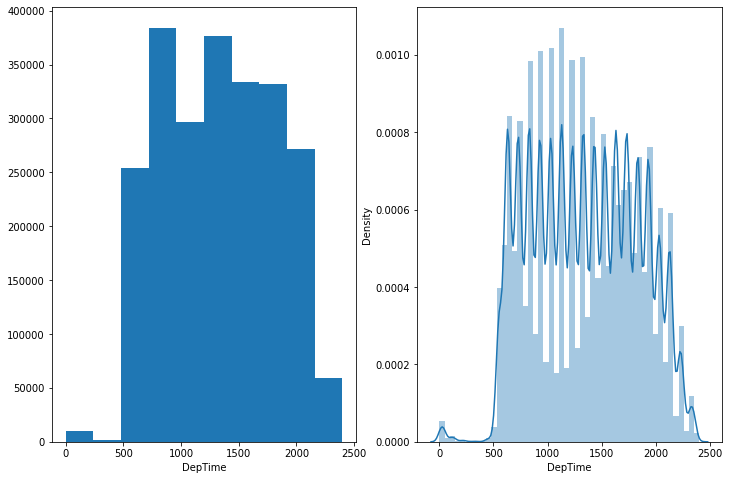


Comments:
The feature DepTime has right skewed distribution
The feature DepTime has negative kurtosis

 * Checking outliers:


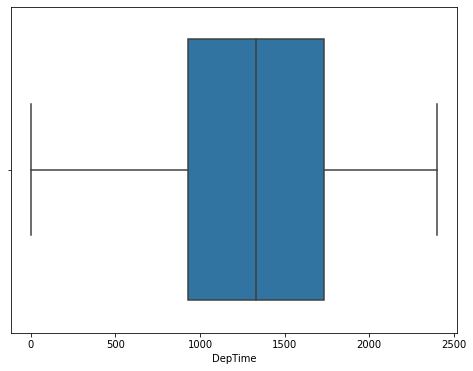


Comments:
The feature DepTime has no outliers

#########################################################################
Do univariate analysis for the feature CRSDepTime

 * Compute the measures of central tendency and dispersion for CRSDepTime:
min: 0 	 max: 2359 
mean: 1329.28 	 median: 1322.0 
std: 466.06 	 var: 217214.8 
q1: 925.0 	 q3: 1720.0 
skew: 0.08 	 kurtosis: -1.05

 * Visualize the histogram and distribution plots of CRSDepTime


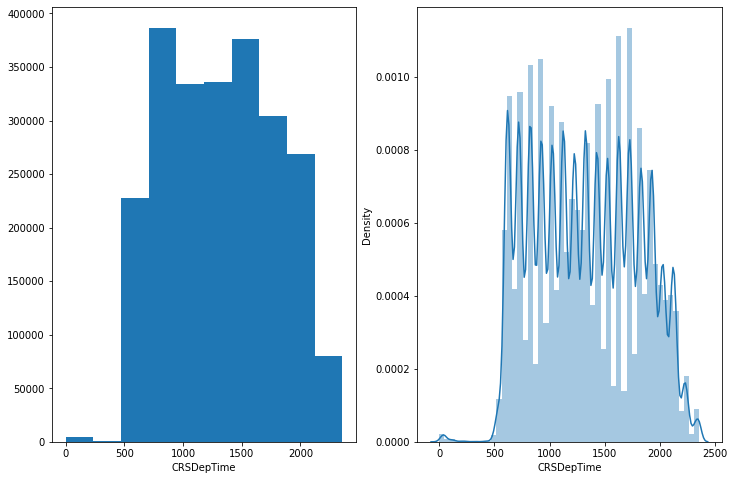


Comments:
The feature CRSDepTime has right skewed distribution
The feature CRSDepTime has negative kurtosis

 * Checking outliers:


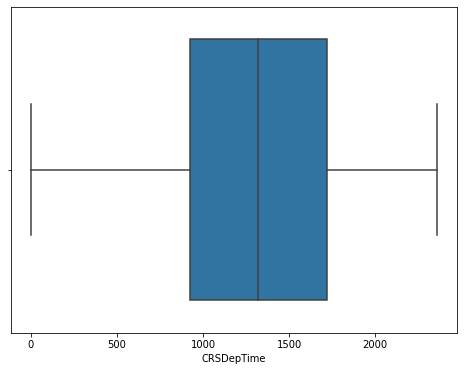


Comments:
The feature CRSDepTime has no outliers

#########################################################################
Do univariate analysis for the feature ArrTime

 * Compute the measures of central tendency and dispersion for ArrTime:
min: 1.0 	 max: 2400.0 
mean: 1485.83 	 median: 1516.0 
std: 508.13 	 var: 258195.61 
q1: 1110.0 	 q3: 1914.0 
skew: -0.34 	 kurtosis: -0.33

 * Visualize the histogram and distribution plots of ArrTime


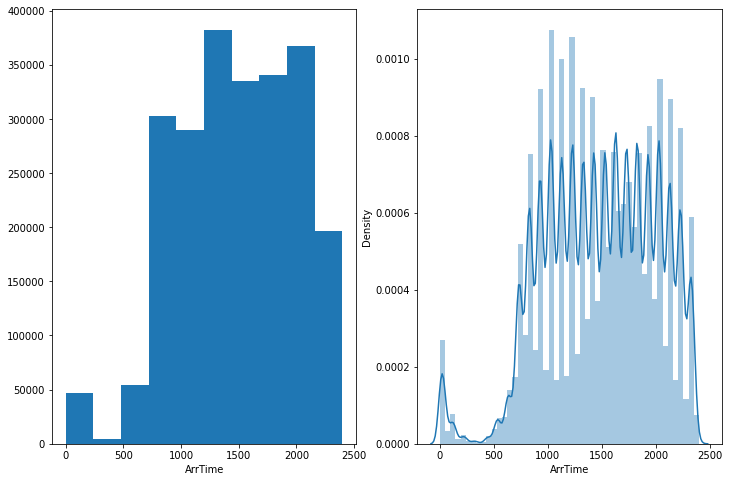


Comments:
The feature ArrTime has left skewed distribution
The feature ArrTime has negative kurtosis

 * Checking outliers:


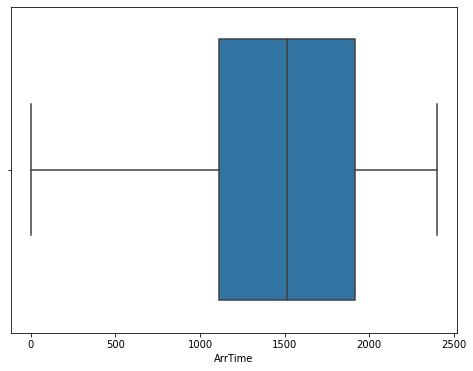


Comments:
The feature ArrTime has no outliers

#########################################################################
Do univariate analysis for the feature CRSArrTime

 * Compute the measures of central tendency and dispersion for CRSArrTime:
min: 1 	 max: 2359 
mean: 1495.85 	 median: 1519.0 
std: 484.81 	 var: 235044.03 
q1: 1115.0 	 q3: 1910.0 
skew: -0.21 	 kurtosis: -0.59

 * Visualize the histogram and distribution plots of CRSArrTime


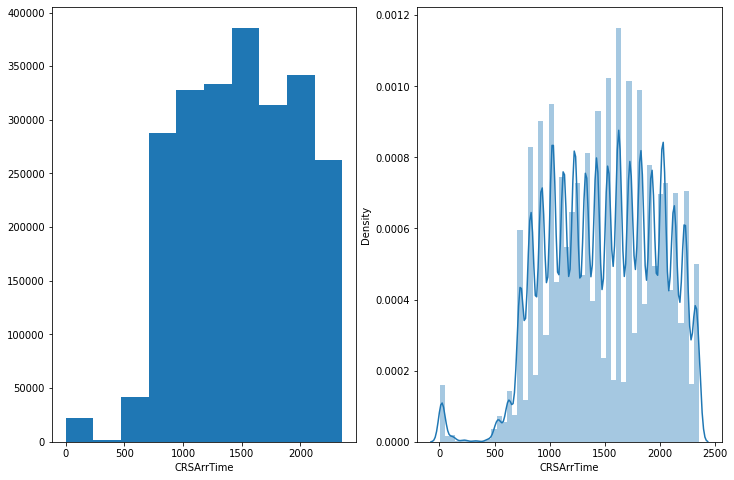


Comments:
The feature CRSArrTime has left skewed distribution
The feature CRSArrTime has negative kurtosis

 * Checking outliers:


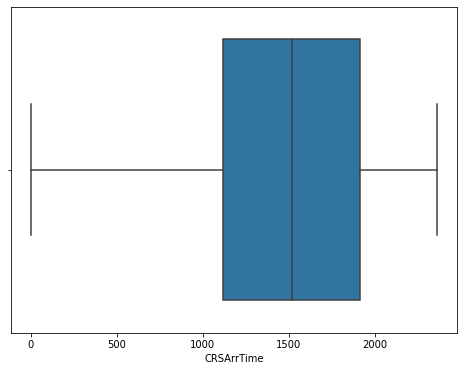


Comments:
The feature CRSArrTime has no outliers

#########################################################################
Do univariate analysis for the feature FlightNum

 * Compute the measures of central tendency and dispersion for FlightNum:
min: 1 	 max: 9740 
mean: 2193.09 	 median: 1529.0 
std: 1942.08 	 var: 3771680.53 
q1: 596.0 	 q3: 3574.0 
skew: 0.92 	 kurtosis: -0.21

 * Visualize the histogram and distribution plots of FlightNum


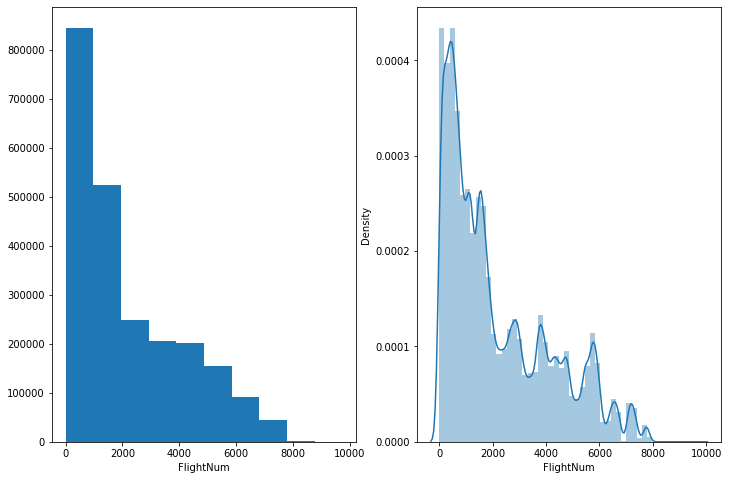


Comments:
The feature FlightNum has right skewed distribution
The feature FlightNum has negative kurtosis

 * Checking outliers:


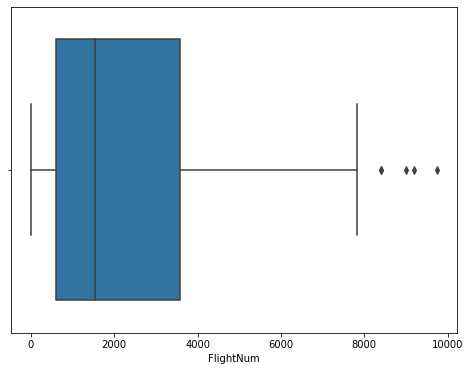


Comments:
The feature FlightNum has outliers

#########################################################################
Do univariate analysis for the feature ActualElapsedTime

 * Compute the measures of central tendency and dispersion for ActualElapsedTime:
min: 14.0 	 max: 905.0 
mean: 128.62 	 median: 111.0 
std: 70.25 	 var: 4935.49 
q1: 78.0 	 q3: 160.0 
skew: 1.47 	 kurtosis: 2.76

 * Visualize the histogram and distribution plots of ActualElapsedTime


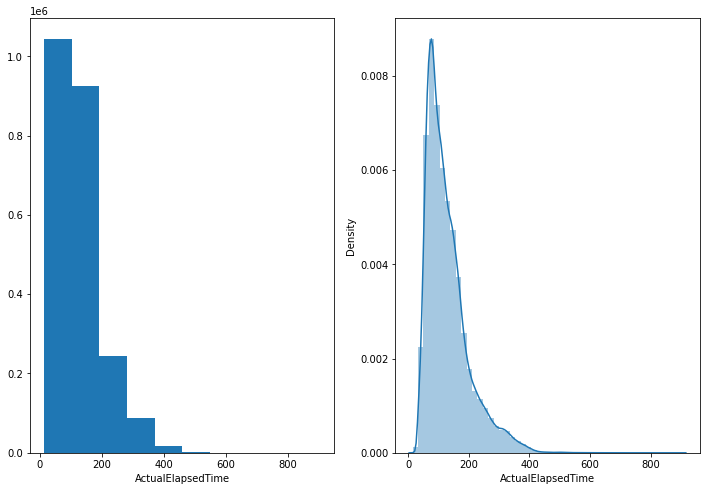


Comments:
The feature ActualElapsedTime has right skewed distribution
The feature ActualElapsedTime has negative kurtosis

 * Checking outliers:


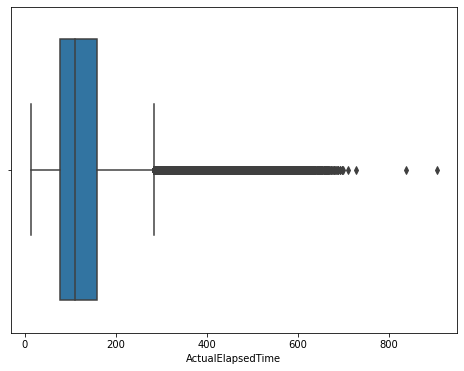


Comments:
The feature ActualElapsedTime has outliers

#########################################################################
Do univariate analysis for the feature CRSElapsedTime

 * Compute the measures of central tendency and dispersion for CRSElapsedTime:
min: -21.0 	 max: 660.0 
mean: 129.73 	 median: 112.0 
std: 69.72 	 var: 4860.44 
q1: 80.0 	 q3: 160.0 
skew: 1.5 	 kurtosis: 2.8

 * Visualize the histogram and distribution plots of CRSElapsedTime


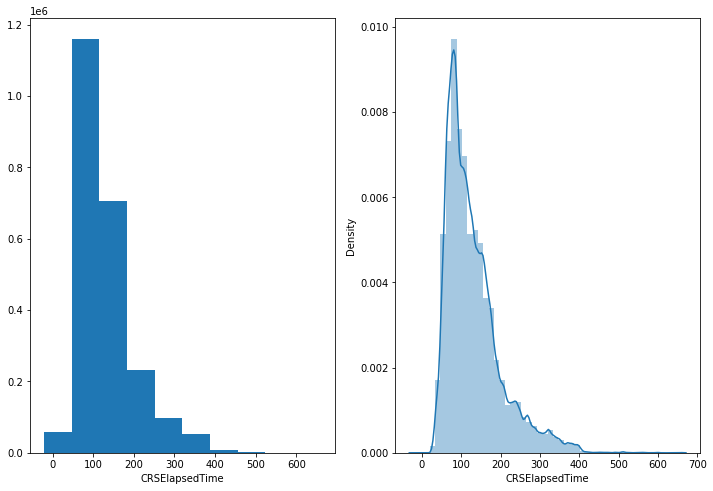


Comments:
The feature CRSElapsedTime has right skewed distribution
The feature CRSElapsedTime has negative kurtosis

 * Checking outliers:


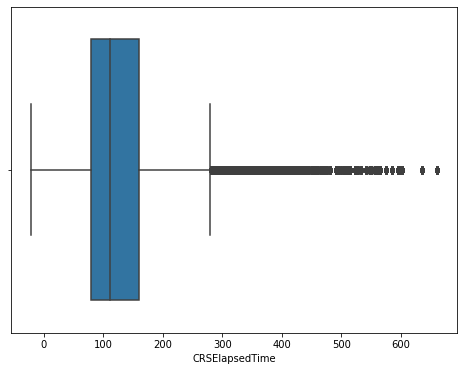


Comments:
The feature CRSElapsedTime has outliers

#########################################################################
Do univariate analysis for the feature AirTime

 * Compute the measures of central tendency and dispersion for AirTime:
min: 0.0 	 max: 886.0 
mean: 105.1 	 median: 87.0 
std: 67.67 	 var: 4578.96 
q1: 56.0 	 q3: 134.0 
skew: 1.54 	 kurtosis: 2.97

 * Visualize the histogram and distribution plots of AirTime


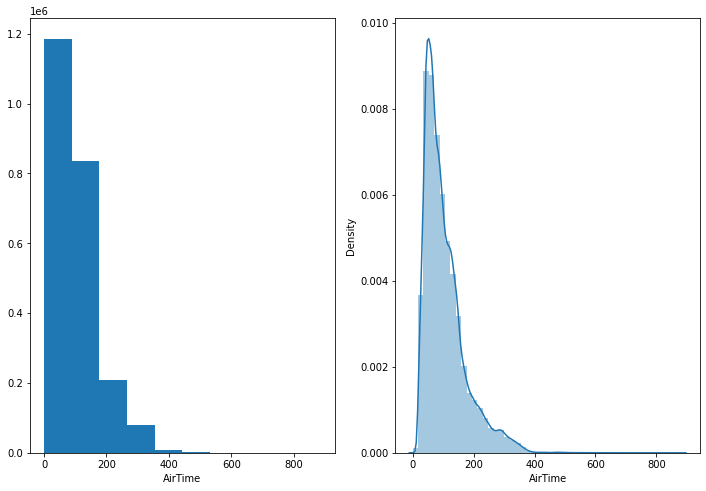


Comments:
The feature AirTime has right skewed distribution
The feature AirTime has negative kurtosis

 * Checking outliers:


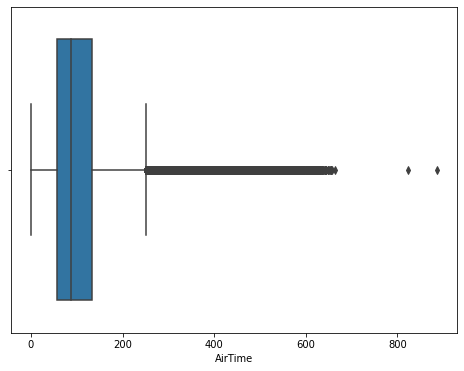


Comments:
The feature AirTime has outliers

#########################################################################
Do univariate analysis for the feature ArrDelay

 * Compute the measures of central tendency and dispersion for ArrDelay:
min: -91.0 	 max: 2461.0 
mean: 10.27 	 median: 0.0 
std: 39.63 	 var: 1570.88 
q1: -9.0 	 q3: 15.0 
skew: 5.27 	 kurtosis: 74.54

 * Visualize the histogram and distribution plots of ArrDelay


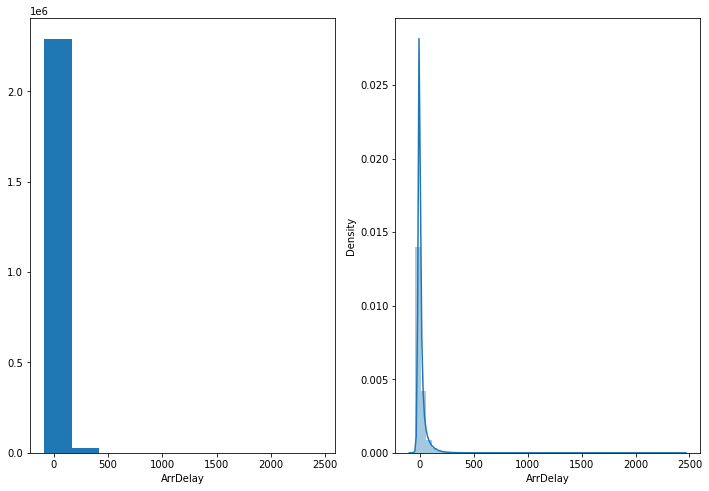


Comments:
The feature ArrDelay has right skewed distribution
The feature ArrDelay has positive kurtosis

 * Checking outliers:


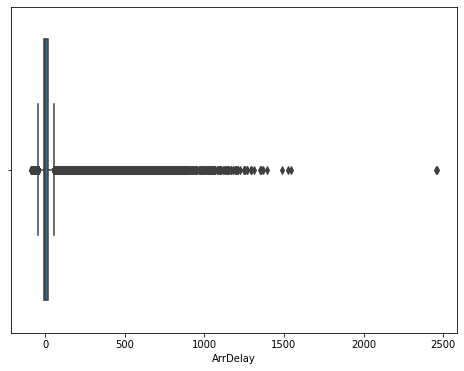


Comments:
The feature ArrDelay has outliers

#########################################################################
Do univariate analysis for the feature DepDelay

 * Compute the measures of central tendency and dispersion for DepDelay:
min: -92.0 	 max: 2467.0 
mean: 11.39 	 median: 0.0 
std: 36.42 	 var: 1326.61 
q1: -4.0 	 q3: 11.0 
skew: 6.31 	 kurtosis: 100.37

 * Visualize the histogram and distribution plots of DepDelay


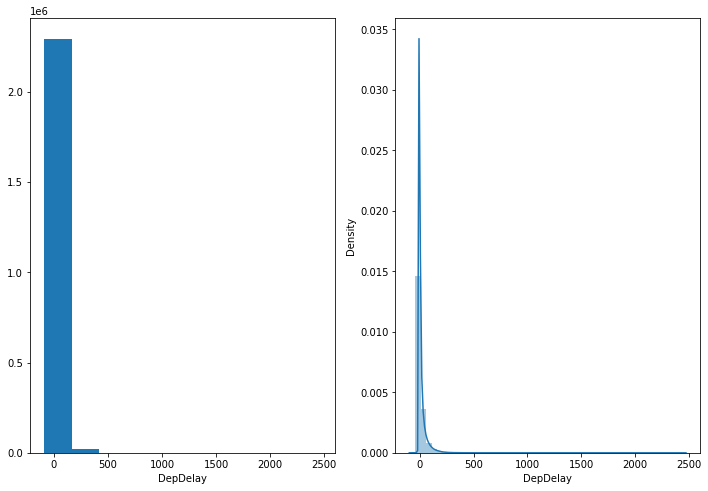


Comments:
The feature DepDelay has right skewed distribution
The feature DepDelay has positive kurtosis

 * Checking outliers:


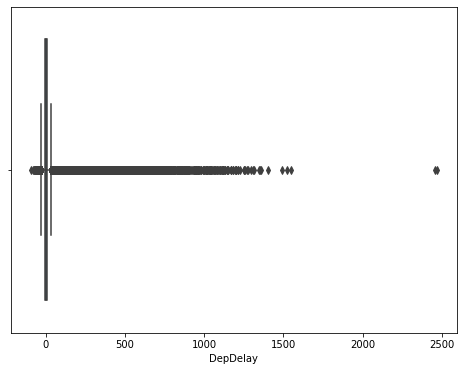


Comments:
The feature DepDelay has outliers

#########################################################################
Do univariate analysis for the feature Distance

 * Compute the measures of central tendency and dispersion for Distance:
min: 24 	 max: 4962 
mean: 729.81 	 median: 585.0 
std: 559.16 	 var: 312655.35 
q1: 328.0 	 q3: 964.0 
skew: 1.62 	 kurtosis: 3.32

 * Visualize the histogram and distribution plots of Distance


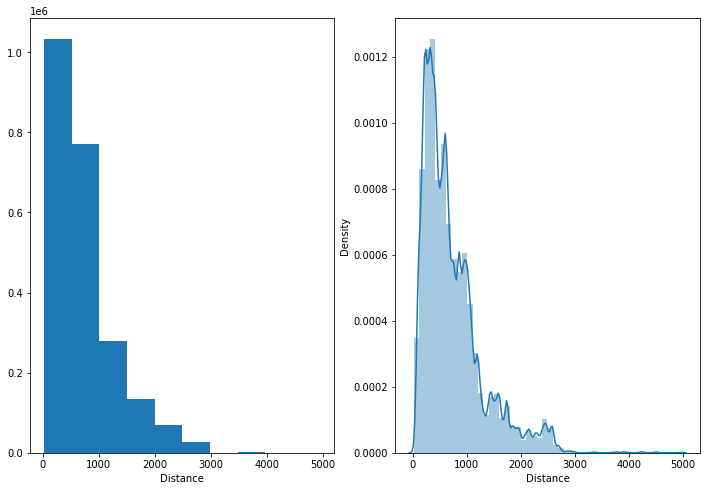


Comments:
The feature Distance has right skewed distribution
The feature Distance has positive kurtosis

 * Checking outliers:


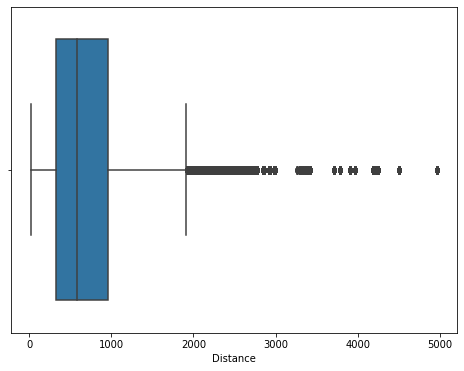


Comments:
The feature Distance has outliers

#########################################################################
Do univariate analysis for the feature TaxiIn

 * Compute the measures of central tendency and dispersion for TaxiIn:
min: 0.0 	 max: 213.0 
mean: 6.84 	 median: 6.0 
std: 4.85 	 var: 23.49 
q1: 4.0 	 q3: 8.0 
skew: 4.52 	 kurtosis: 53.96

 * Visualize the histogram and distribution plots of TaxiIn


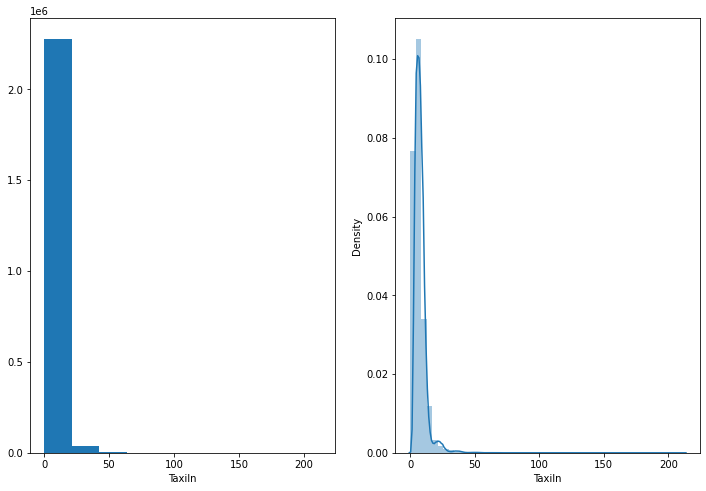


Comments:
The feature TaxiIn has right skewed distribution
The feature TaxiIn has positive kurtosis

 * Checking outliers:


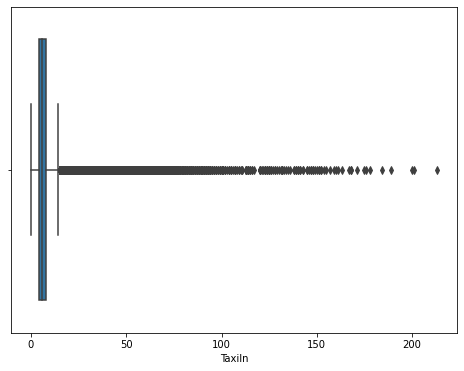


Comments:
The feature TaxiIn has outliers

#########################################################################
Do univariate analysis for the feature TaxiOut

 * Compute the measures of central tendency and dispersion for TaxiOut:
min: 0.0 	 max: 383.0 
mean: 16.68 	 median: 14.0 
std: 11.01 	 var: 121.26 
q1: 10.0 	 q3: 19.0 
skew: 4.14 	 kurtosis: 38.11

 * Visualize the histogram and distribution plots of TaxiOut


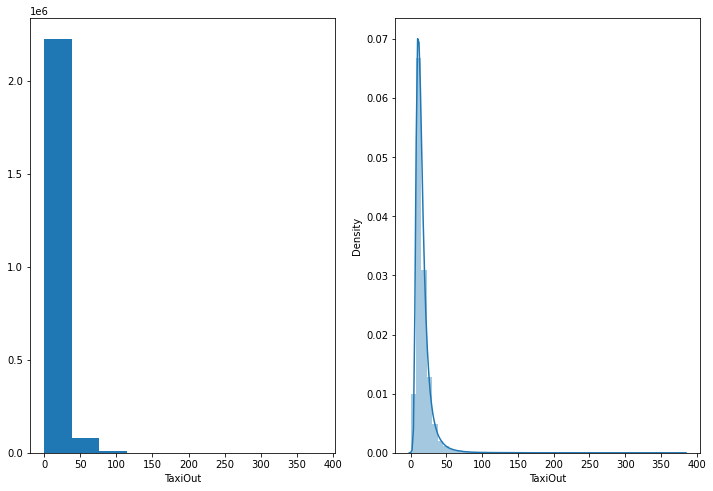


Comments:
The feature TaxiOut has right skewed distribution
The feature TaxiOut has positive kurtosis

 * Checking outliers:


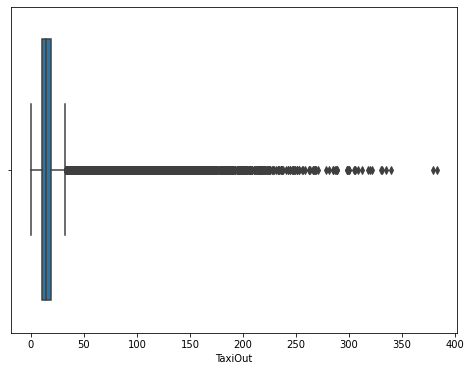


Comments:
The feature TaxiOut has outliers

#########################################################################
Do univariate analysis for the feature CarrierDelay

 * Compute the measures of central tendency and dispersion for CarrierDelay:
min: 0.0 	 max: 2436.0 
mean: 15.75 	 median: 0.0 
std: 40.04 	 var: 1602.84 
q1: 0.0 	 q3: 16.0 
skew: 8.43 	 kurtosis: 153.24

 * Visualize the histogram and distribution plots of CarrierDelay


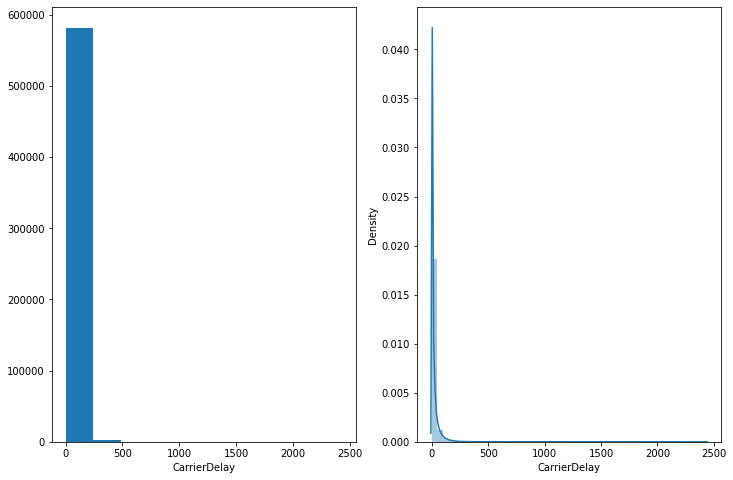


Comments:
The feature CarrierDelay has right skewed distribution
The feature CarrierDelay has positive kurtosis

 * Checking outliers:


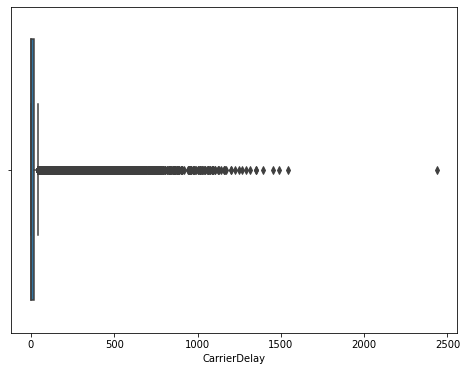


Comments:
The feature CarrierDelay has outliers

#########################################################################
Do univariate analysis for the feature WeatherDelay

 * Compute the measures of central tendency and dispersion for WeatherDelay:
min: 0.0 	 max: 1148.0 
mean: 2.94 	 median: 0.0 
std: 19.17 	 var: 367.36 
q1: 0.0 	 q3: 0.0 
skew: 13.81 	 kurtosis: 335.47

 * Visualize the histogram and distribution plots of WeatherDelay


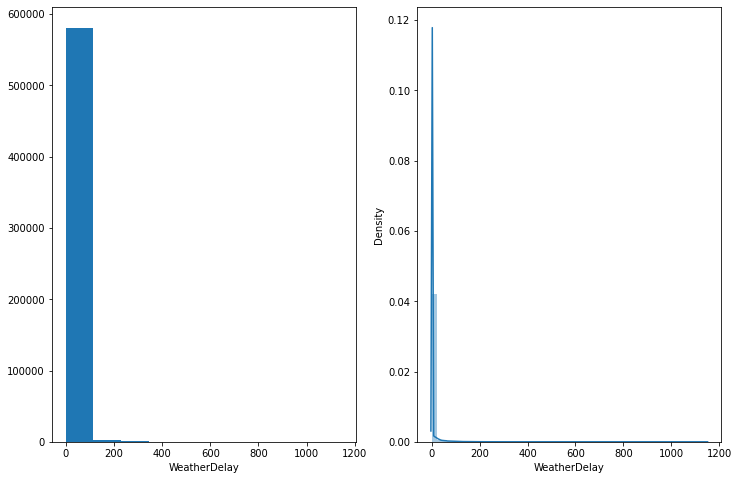


Comments:
The feature WeatherDelay has right skewed distribution
The feature WeatherDelay has positive kurtosis

 * Checking outliers:


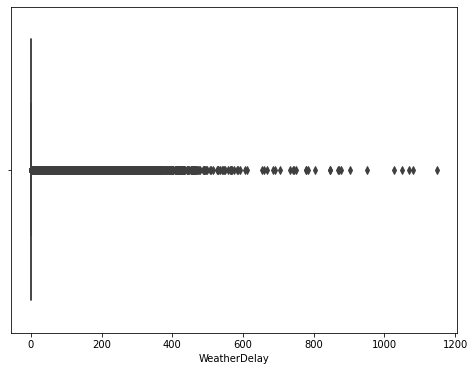


Comments:
The feature WeatherDelay has outliers

#########################################################################
Do univariate analysis for the feature NASDelay

 * Compute the measures of central tendency and dispersion for NASDelay:
min: 0.0 	 max: 1357.0 
mean: 16.16 	 median: 5.0 
std: 30.53 	 var: 932.34 
q1: 0.0 	 q3: 20.0 
skew: 5.26 	 kurtosis: 61.52

 * Visualize the histogram and distribution plots of NASDelay


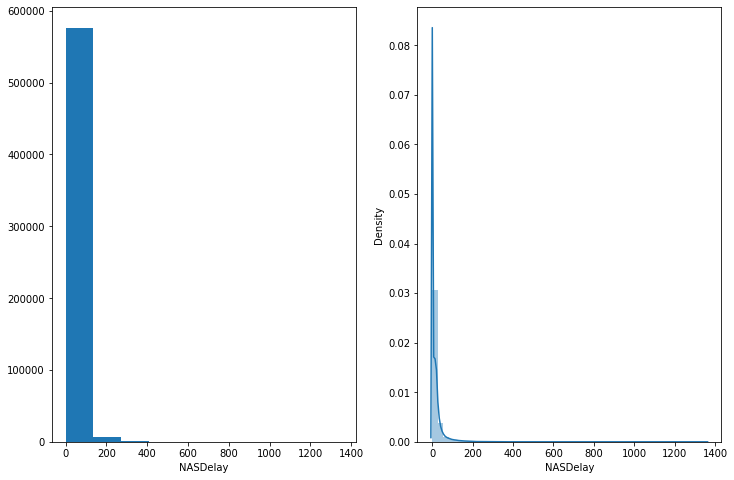


Comments:
The feature NASDelay has right skewed distribution
The feature NASDelay has positive kurtosis

 * Checking outliers:


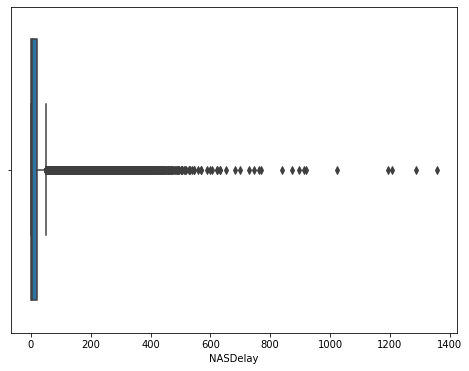


Comments:
The feature NASDelay has outliers

#########################################################################
Do univariate analysis for the feature SecurityDelay

 * Compute the measures of central tendency and dispersion for SecurityDelay:
min: 0.0 	 max: 392.0 
mean: 0.08 	 median: 0.0 
std: 1.74 	 var: 3.04 
q1: 0.0 	 q3: 0.0 
skew: 51.03 	 kurtosis: 5906.61

 * Visualize the histogram and distribution plots of SecurityDelay


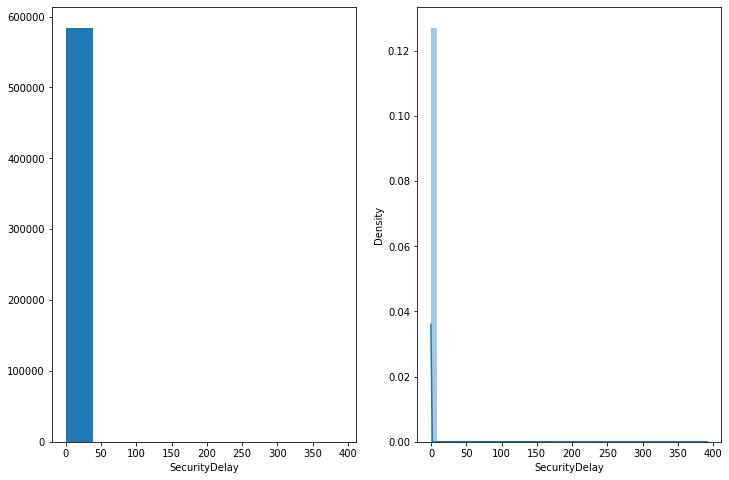


Comments:
The feature SecurityDelay has right skewed distribution
The feature SecurityDelay has positive kurtosis

 * Checking outliers:


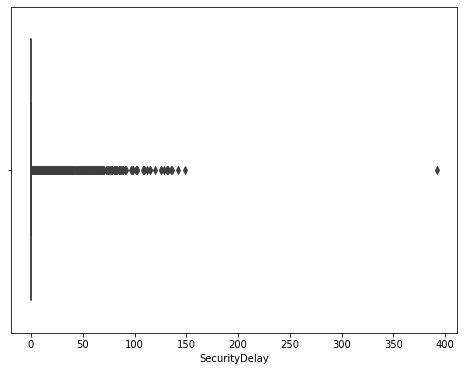


Comments:
The feature SecurityDelay has outliers

#########################################################################
Do univariate analysis for the feature LateAircraftDelay

 * Compute the measures of central tendency and dispersion for LateAircraftDelay:
min: 0.0 	 max: 1254.0 
mean: 20.98 	 median: 0.0 
std: 38.62 	 var: 1491.29 
q1: 0.0 	 q3: 27.0 
skew: 3.5 	 kurtosis: 23.23

 * Visualize the histogram and distribution plots of LateAircraftDelay


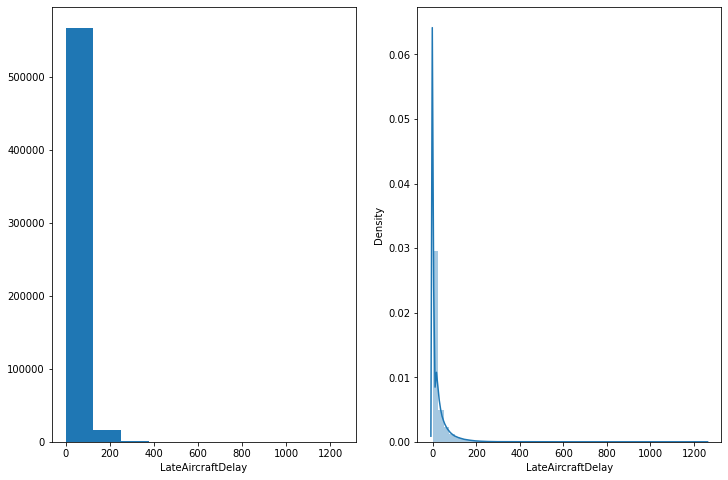


Comments:
The feature LateAircraftDelay has right skewed distribution
The feature LateAircraftDelay has positive kurtosis

 * Checking outliers:


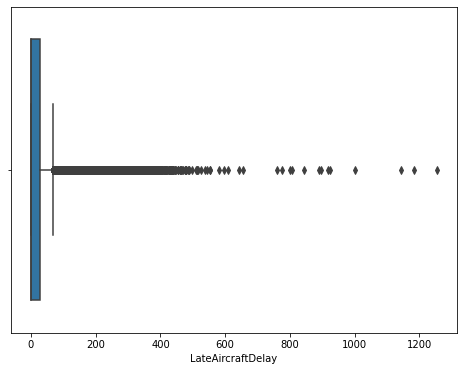


Comments:
The feature LateAircraftDelay has outliers


In [ ]:
#Use the above function to do univariate analysis for all continuous variables
for num in number_list:
    print('\n#########################################################################')
    print('Do univariate analysis for the feature %s' %(num))
    continuous_univariate_analysis(flights, num)

In [ ]:
#Remove column 'Year', 'Cancelled' and column 'Diverted' as mentioned in the above comments.
flights = flights.drop(columns = ['Year', 'Cancelled', 'Diverted'], axis = 1)
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319117 entries, 0 to 2319116
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DayofMonth         int64  
 2   DayOfWeek          int64  
 3   DepTime            float64
 4   CRSDepTime         int64  
 5   ArrTime            float64
 6   CRSArrTime         int64  
 7   UniqueCarrier      object 
 8   FlightNum          int64  
 9   TailNum            object 
 10  ActualElapsedTime  float64
 11  CRSElapsedTime     float64
 12  AirTime            float64
 13  ArrDelay           float64
 14  DepDelay           float64
 15  Origin             object 
 16  Dest               object 
 17  Distance           int64  
 18  TaxiIn             float64
 19  TaxiOut            float64
 20  CarrierDelay       float64
 21  WeatherDelay       float64
 22  NASDelay           float64
 23  SecurityDelay      float64
 24  LateAircraftDelay  float64
dtypes: float64(14), in

In [ ]:
#Visualize scatter plot between each numeric feature and 'ArrDelay'
plt.figure(figsize=(20,200))
for i in range(len(number_list)):
    plt.subplot(len(number_list),1,i+1)
    sb.scatterplot(flights[number_list[i]], flights['ArrDelay'])
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

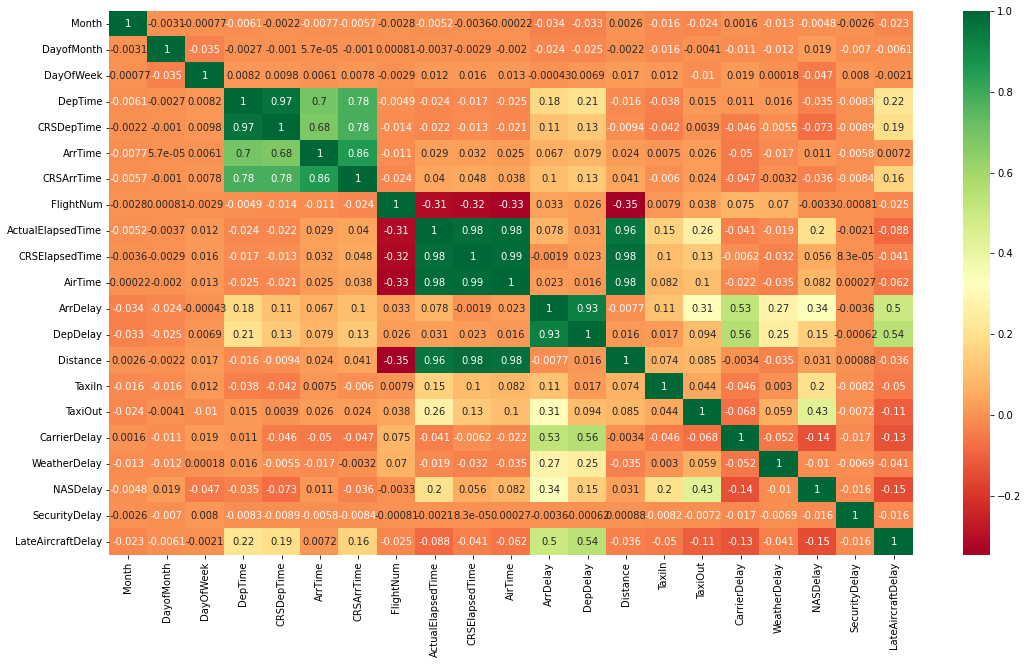

In [ ]:
#Visualize correlation matrix to determine the intensity of the relationships between numeric features and 'ArrDelay'
corrmat = flights.corr()
plt.figure(figsize=(18,10))
g = sb.heatmap(corrmat, cmap='RdYlGn', annot=True)
plt.show()

### Comments:
- By using scatter plots and correlation matrix together, we can see that 'ArrDelay' is proportional to 'DepDelay' with strong intensity because the value (0.93) is larger than 0.7.  
- In addition, 'ArrDelay' is proportional to 'CarrierDelay' and 'LateAircraftDelay' with medium intensity because the values (0.53 and 0.5) are in the range (0.5, 0.7).  
- Furthermore, 'ArrDelay' is proportional to 'TaxiOut' and 'NASDelay' with weak intensity because the values (0.31 and 0.34) are in the range (0.3, 0.5).  
- And 'ArrDelay' has no relationships with the other features.

In [ ]:
#For the features with small number of groups inside, we will do counts, draw bar chart and treemap (or pie chart)
#Define a function to do univariate analysis for a categorial variable
def categorial_univariate_analysis(df, feature):
    print('##########################################################')
    print("* Do univariate analysis for the feature '%s'" %(feature))
    df_copy = df[feature].dropna().reset_index().drop('index', axis = 1).copy()
    feature_col = df_copy[feature]
    feature_count = feature_col.value_counts()
    
    #If there are more than 10 categories in a feature, keep 10 categories with the highest counts, 
    #and group the rest of categories into one common group named 'Others'
    feature_num = len(feature_count)
    if feature_num > 10:
        minority_labels = feature_col.isin(feature_count[feature_count <= feature_count[10]].index)
        feature_col = df_copy[feature]
        feature_col[minority_labels] = 'Others'
        feature_count = feature_col.value_counts()
        print("""Because there are %d categories in the feature '%s', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.""" %(feature_num, feature))
        #Count quantity is also number of flights
        print("Number of flights of each category in the feature '%s'" %(feature))
        print(feature_count)
        
    else:
        print("Number of flights of each category in the feature '%s'" %(feature))
        print(feature_count)

    #Plot the bar chart for the feature
    print("\nBar chart of the feature '%s'" %(feature))
    plt.figure(figsize=(12,8))
    feature_count.plot.bar()
    plt.xlabel("Categories in the feature '%s'" %(feature))
    plt.ylabel('Number of flights')
    plt.xticks(rotation=45)
    plt.show()

    #Visualize counts in percentage format using treemap
    plt.figure(figsize=(14,12))
    labels=['%s\n(%.1f%%)'%(label) for label in zip(feature_count.index, round(feature_count/sum(feature_count)*100,2))]
    sq.plot(sizes=feature_count,label=labels,color=sb.color_palette('coolwarm_r'),text_kwargs={'fontsize':12})
    plt.title("Percentage of number of flights of all categories in treemap of the feature '%s'" %(feature))
    plt.axis('off')
    plt.show()

##########################################################
* Do univariate analysis for the feature 'Month'
Number of flights of each category in the feature 'Month'
3    598343
1    587130
4    586723
2    546921
Name: Month, dtype: int64

Bar chart of the feature 'Month'


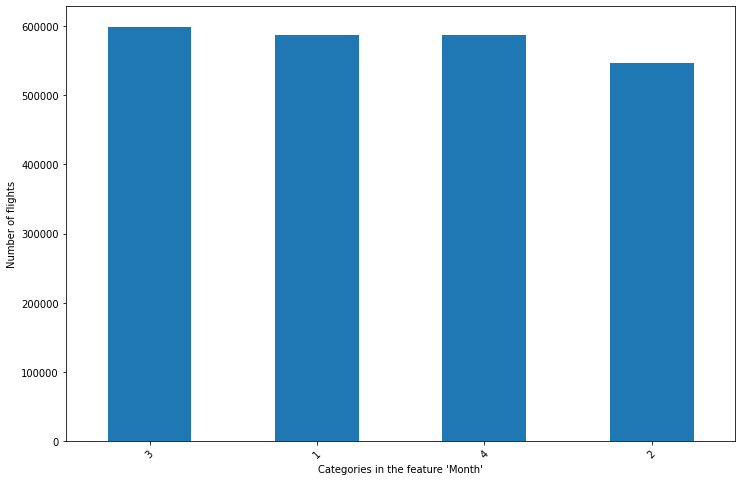

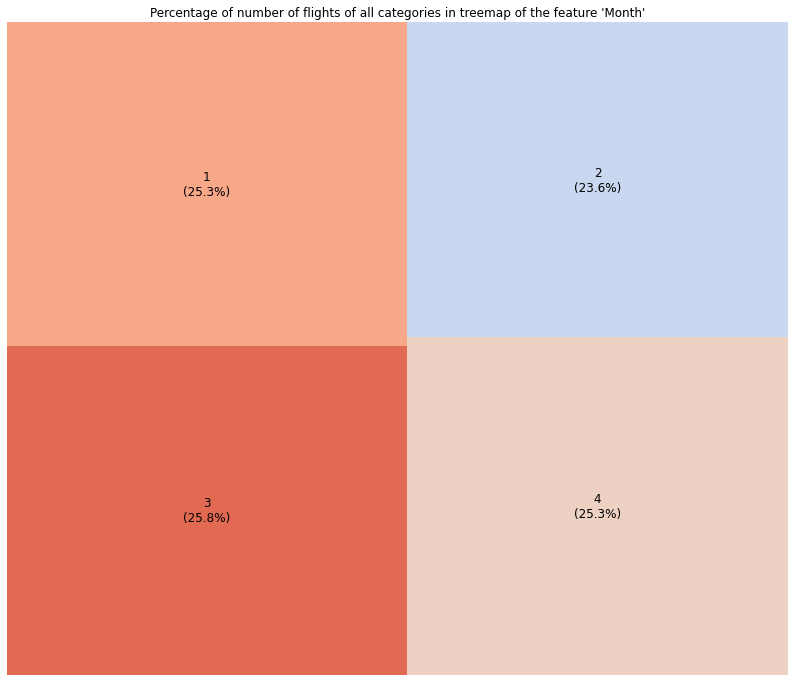

##########################################################
* Do univariate analysis for the feature 'DayofMonth'
Because there are 31 categories in the feature 'DayofMonth', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.
Number of flights of each category in the feature 'DayofMonth'
Others    1446477
14          80617
28          80203
24          80083
25          79752
7           79459
21          79323
11          78896
18          78868
3           78826
20          78537
17          78076
Name: DayofMonth, dtype: int64

Bar chart of the feature 'DayofMonth'


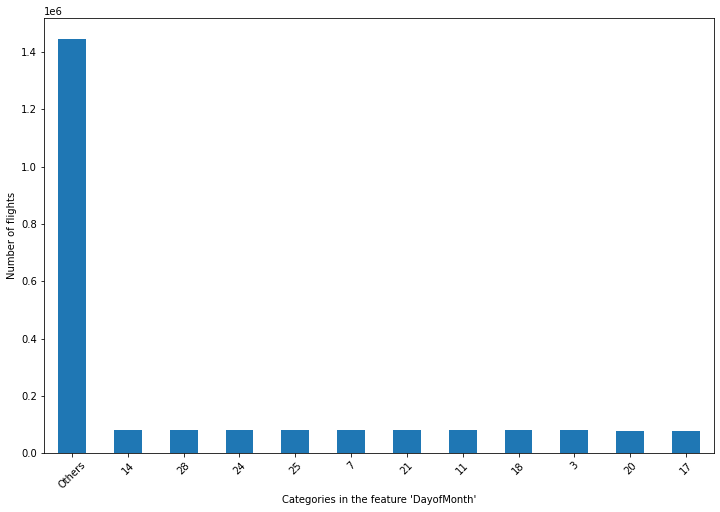

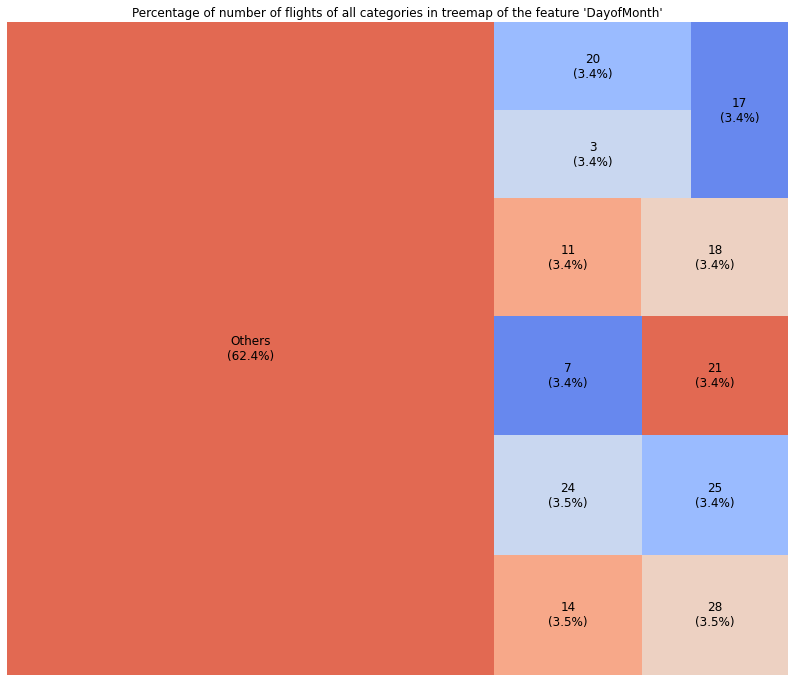

##########################################################
* Do univariate analysis for the feature 'DayOfWeek'
Number of flights of each category in the feature 'DayOfWeek'
3    354455
2    346043
4    340309
5    338154
1    337658
7    321369
6    281129
Name: DayOfWeek, dtype: int64

Bar chart of the feature 'DayOfWeek'


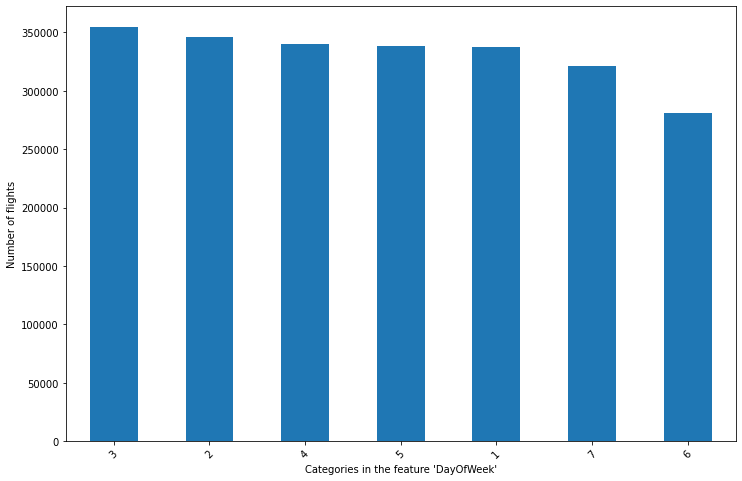

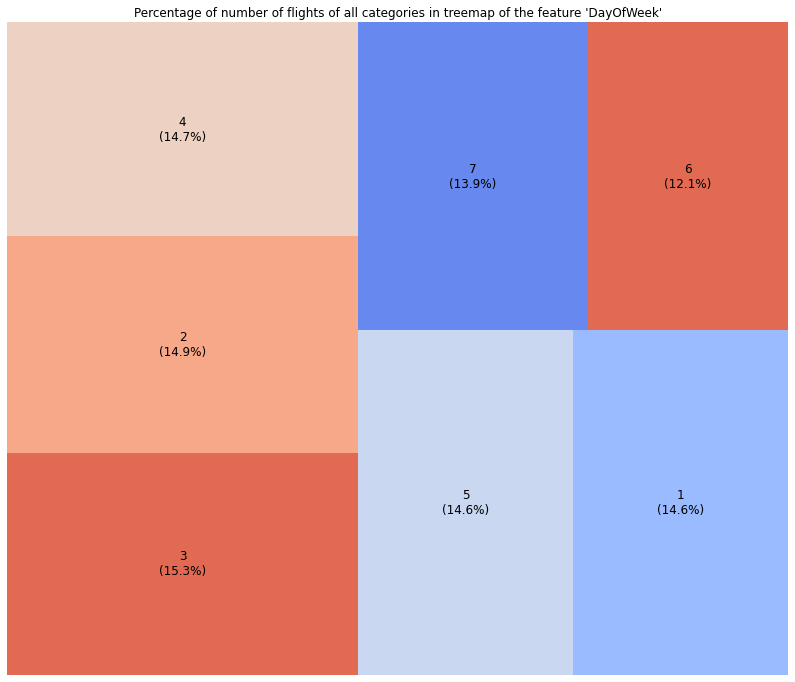

##########################################################
* Do univariate analysis for the feature 'UniqueCarrier'
Because there are 20 categories in the feature 'UniqueCarrier', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.
Number of flights of each category in the feature 'UniqueCarrier'
Others    580894
WN        393732
AA        193114
OO        187917
MQ        158426
US        150891
UA        149156
DL        147987
XE        134444
NW        121162
CO        101394
Name: UniqueCarrier, dtype: int64

Bar chart of the feature 'UniqueCarrier'


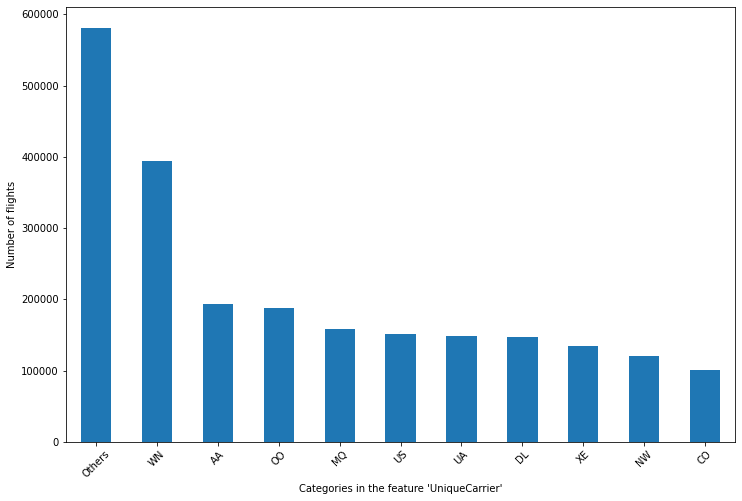

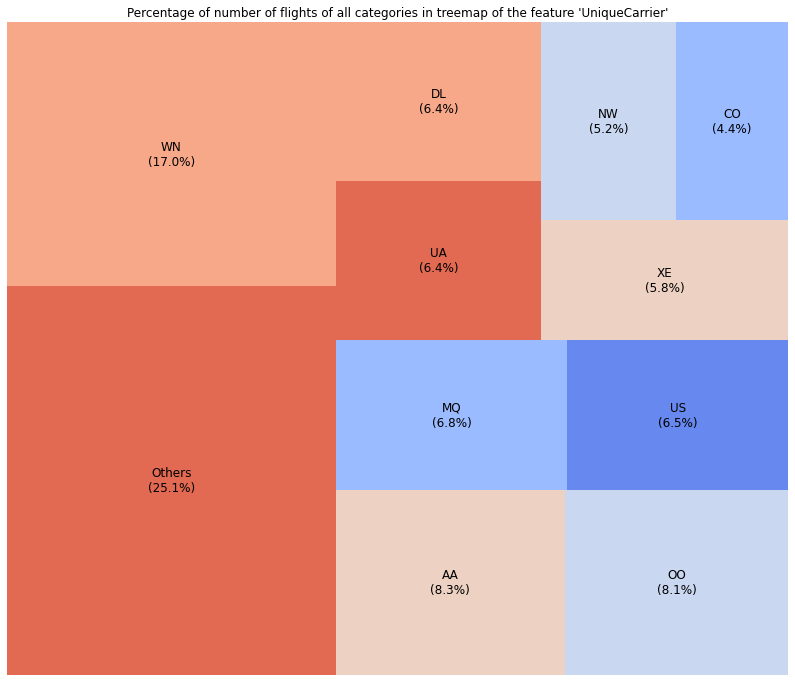

##########################################################
* Do univariate analysis for the feature 'TailNum'
Because there are 5025 categories in the feature 'TailNum', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.
Number of flights of each category in the feature 'TailNum'
Others    2304922
N693BR       1522
N476HA       1490
N646BR       1481
N485HA       1441
N486HA       1439
N484HA       1425
N487HA       1417
N475HA       1411
N477HA       1284
N651BR       1283
Name: TailNum, dtype: int64

Bar chart of the feature 'TailNum'


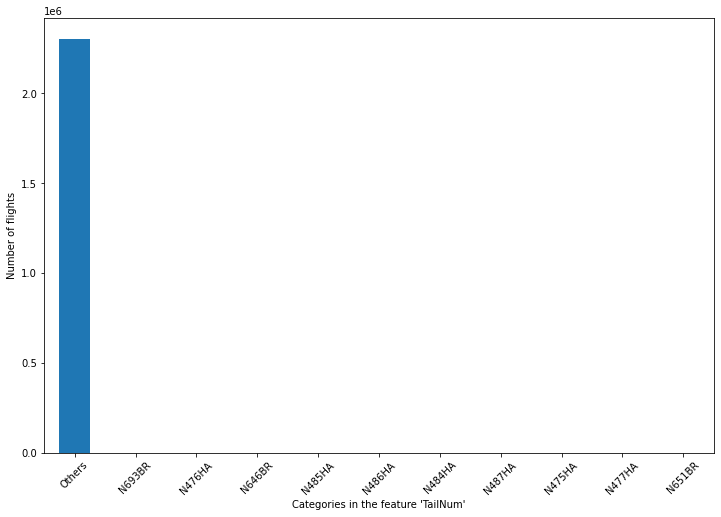

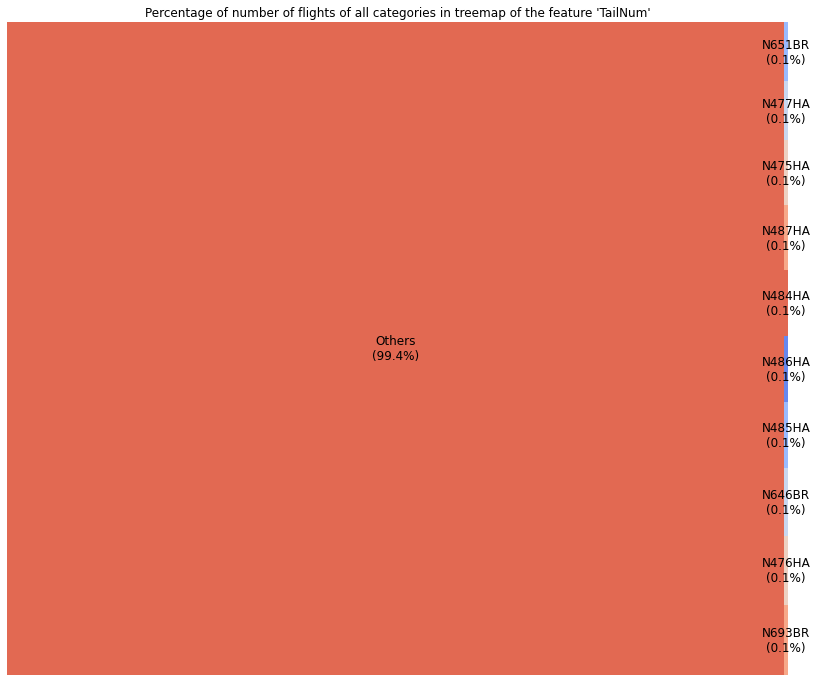

##########################################################
* Do univariate analysis for the feature 'Origin'
Because there are 291 categories in the feature 'Origin', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.
Number of flights of each category in the feature 'Origin'
Others    1547223
ATL        133852
ORD        109196
DFW         88575
DEN         77023
LAX         72096
PHX         68434
IAH         61601
LAS         58802
DTW         54616
SLC         47699
Name: Origin, dtype: int64

Bar chart of the feature 'Origin'


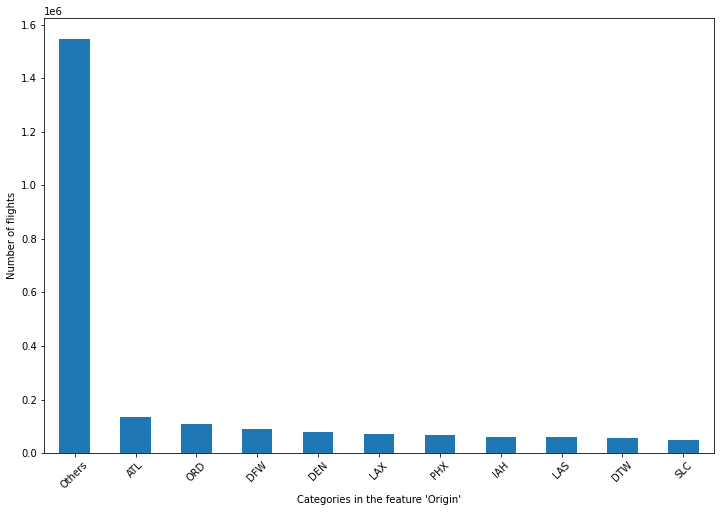

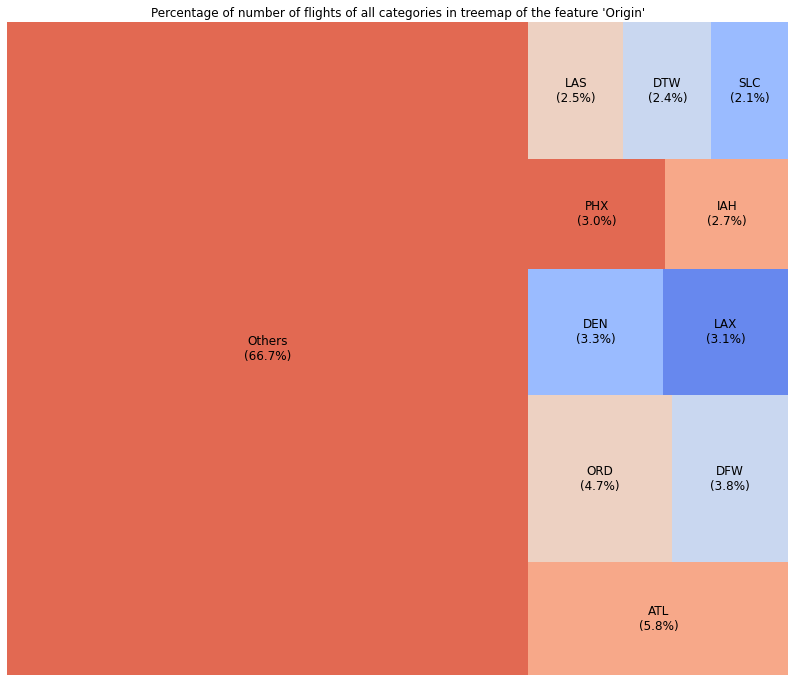

##########################################################
* Do univariate analysis for the feature 'Dest'
Because there are 291 categories in the feature 'Dest', we keep 10 categories with the highest counts 
        and group the rest of categories into one common group named 'Others'.
Number of flights of each category in the feature 'Dest'
Others    1548913
ATL        133521
ORD        108746
DFW         88146
DEN         77010
LAX         72079
PHX         68217
IAH         61504
LAS         58853
DTW         54474
SLC         47654
Name: Dest, dtype: int64

Bar chart of the feature 'Dest'


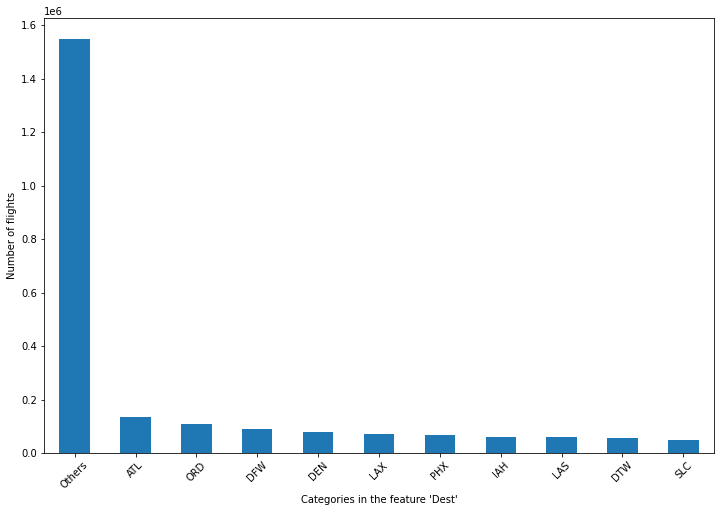

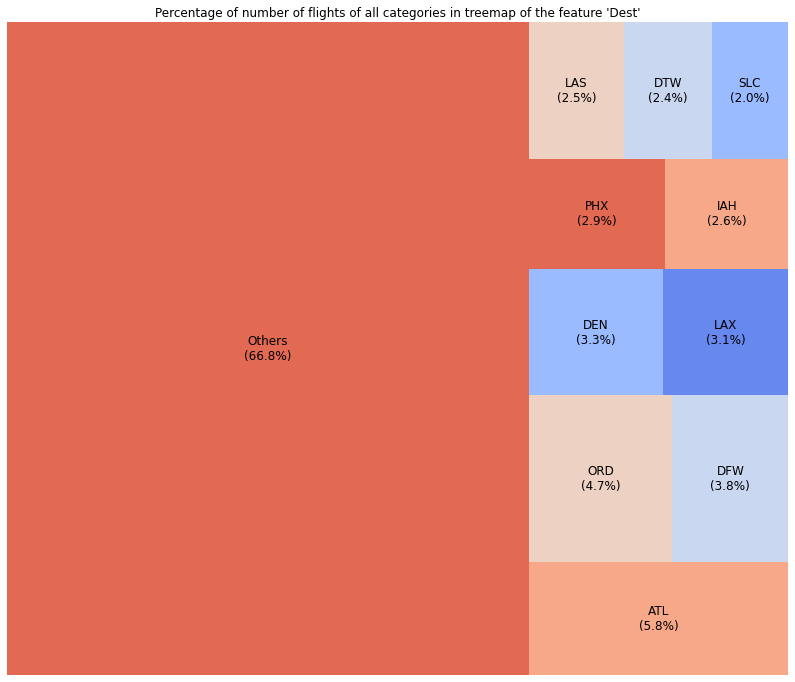

In [ ]:
#Use the above function to do analysis
analysis_list = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest']
for feature in analysis_list:
    categorial_univariate_analysis(flights, feature)

## 2. Apply models in Naïve Bayes, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting and XGBoost.
- Based on the above analysis, the features selected to create models for predicting the target 'ArrDelay' are: 'DepDelay',  'CarrierDelay', 'LateAircraftDelay', 'TaxiOut', 'NASDelay', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest'.  
- Because our concern is to determine whether a flight is late or not, we have to create a new column to label the delay for all flights.  
- Besides, for the column 'DepDelay', we will make it more meaningful by creating a new column to classify whether the departure of a flight is late or not.  
- At the stage of creating models, we will use PySpark ML to speed up the calculation because of big dataset.  

In [ ]:
#Create a new column to classify whether the departure of a flight is late or not.
#'DepDelay' > 0: 1 (late), otherwise 0 (not late)
flights['DepStatus'] = [1 if minutes > 0 else 0 for minutes in flights['DepDelay']]
flights.head(5)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepStatus
0,1,3,4,1343.0,1325,1451.0,1435,WN,588,N240WN,68.0,70.0,55.0,16.0,18.0,HOU,LIT,393,4.0,9.0,16.0,0.0,0.0,0.0,0.0,1
1,1,3,4,1125.0,1120,1247.0,1245,WN,1343,N523SW,82.0,85.0,71.0,2.0,5.0,HOU,MAF,441,3.0,8.0,NaN,NaN,NaN,NaN,NaN,1
2,1,3,4,2009.0,2015,2136.0,2140,WN,3841,N280WN,87.0,85.0,71.0,-4.0,-6.0,HOU,MAF,441,2.0,14.0,NaN,NaN,NaN,NaN,NaN,0
3,1,3,4,903.0,855,1203.0,1205,WN,3,N308SA,120.0,130.0,108.0,-2.0,8.0,HOU,MCO,848,5.0,7.0,NaN,NaN,NaN,NaN,NaN,1
4,1,3,4,1423.0,1400,1726.0,1710,WN,25,N462WN,123.0,130.0,107.0,16.0,23.0,HOU,MCO,848,6.0,10.0,16.0,0.0,0.0,0.0,0.0,1


In [ ]:
#Create a new column to classify whether a flight is considered late or not.
#A flight only counts as late if it is more than 30 minutes late
flights['Late'] = [1 if minutes > 30 else 0 for minutes in flights['ArrDelay']]
flights.head(5)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepStatus,Late
0,1,3,4,1343.0,1325,1451.0,1435,WN,588,N240WN,68.0,70.0,55.0,16.0,18.0,HOU,LIT,393,4.0,9.0,16.0,0.0,0.0,0.0,0.0,1,0
1,1,3,4,1125.0,1120,1247.0,1245,WN,1343,N523SW,82.0,85.0,71.0,2.0,5.0,HOU,MAF,441,3.0,8.0,NaN,NaN,NaN,NaN,NaN,1,0
2,1,3,4,2009.0,2015,2136.0,2140,WN,3841,N280WN,87.0,85.0,71.0,-4.0,-6.0,HOU,MAF,441,2.0,14.0,NaN,NaN,NaN,NaN,NaN,0,0
3,1,3,4,903.0,855,1203.0,1205,WN,3,N308SA,120.0,130.0,108.0,-2.0,8.0,HOU,MCO,848,5.0,7.0,NaN,NaN,NaN,NaN,NaN,1,0
4,1,3,4,1423.0,1400,1726.0,1710,WN,25,N462WN,123.0,130.0,107.0,16.0,23.0,HOU,MCO,848,6.0,10.0,16.0,0.0,0.0,0.0,0.0,1,0


In [ ]:
#Extract selected features based on the above analysis
selected_features = ['DepStatus', 'CarrierDelay', 'LateAircraftDelay', 'TaxiOut', 'NASDelay', 
                                 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'Late']
flights_filtered = flights[selected_features]
flights_filtered.head()

,DepStatus,CarrierDelay,LateAircraftDelay,TaxiOut,NASDelay,Month,DayofMonth,DayOfWeek,UniqueCarrier,TailNum,Origin,Dest,Late
0,1,16.0,0.0,9.0,0.0,1,3,4,WN,N240WN,HOU,LIT,0
1,1,NaN,NaN,8.0,NaN,1,3,4,WN,N523SW,HOU,MAF,0
2,0,NaN,NaN,14.0,NaN,1,3,4,WN,N280WN,HOU,MAF,0
3,1,NaN,NaN,7.0,NaN,1,3,4,WN,N308SA,HOU,MCO,0
4,1,16.0,0.0,10.0,0.0,1,3,4,WN,N462WN,HOU,MCO,0


In [ ]:
#Remove all null values
flights_filtered = flights_filtered.dropna().reset_index().drop('index', axis = 1)
flights_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584580 entries, 0 to 584579
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DepStatus          584580 non-null  int64  
 1   CarrierDelay       584580 non-null  float64
 2   LateAircraftDelay  584580 non-null  float64
 3   TaxiOut            584580 non-null  float64
 4   NASDelay           584580 non-null  float64
 5   Month              584580 non-null  int64  
 6   DayofMonth         584580 non-null  int64  
 7   DayOfWeek          584580 non-null  int64  
 8   UniqueCarrier      584580 non-null  object 
 9   TailNum            584580 non-null  object 
 10  Origin             584580 non-null  object 
 11  Dest               584580 non-null  object 
 12  Late               584580 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 58.0+ MB


In [ ]:
#Display the first 5 rows
flights_filtered.head()

,DepStatus,CarrierDelay,LateAircraftDelay,TaxiOut,NASDelay,Month,DayofMonth,DayOfWeek,UniqueCarrier,TailNum,Origin,Dest,Late
0,1,16.0,0.0,9.0,0.0,1,3,4,WN,N240WN,HOU,LIT,0
1,1,16.0,0.0,10.0,0.0,1,3,4,WN,N462WN,HOU,MCO,0
2,1,11.0,15.0,13.0,0.0,1,3,4,WN,N514SW,HOU,MDW,0
3,1,53.0,0.0,10.0,3.0,1,3,4,WN,N215WN,HOU,MDW,1
4,1,10.0,9.0,8.0,20.0,1,3,4,WN,N623SW,HOU,MDW,1


In [ ]:
#Specify data type of all columns in the dataset before creating DataFrame in PySpark
schema = StructType([
                StructField("DepStatus", IntegerType(),True),
                StructField("CarrierDelay", FloatType(),True), 
                StructField("LateAircraftDelay", FloatType(),True),
                StructField("TaxiOut", FloatType(),True),
                StructField("NASDelay", FloatType(),True),
                StructField("Month", IntegerType(),True),
                StructField("DayofMonth", IntegerType(),True), 
                StructField("DayOfWeek", IntegerType(),True), 
                StructField("UniqueCarrier", StringType(),True), 
                StructField("TailNum", StringType(),True),
                StructField("Origin", StringType(),True),
                StructField("Dest", StringType(),True),
                StructField("Late", IntegerType(),True)
                ])

In [ ]:
#Create DataFrame of flights in PySpark
flights_data = spark.createDataFrame(flights_filtered, schema = schema)
flights_data.printSchema()
flights_data.show(3)

root
 |-- DepStatus: integer (nullable = true)
 |-- CarrierDelay: float (nullable = true)
 |-- LateAircraftDelay: float (nullable = true)
 |-- TaxiOut: float (nullable = true)
 |-- NASDelay: float (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Late: integer (nullable = true)

+---------+------------+-----------------+-------+--------+-----+----------+---------+-------------+-------+------+----+----+
|DepStatus|CarrierDelay|LateAircraftDelay|TaxiOut|NASDelay|Month|DayofMonth|DayOfWeek|UniqueCarrier|TailNum|Origin|Dest|Late|
+---------+------------+-----------------+-------+--------+-----+----------+---------+-------------+-------+------+----+----+
|        1|        16.0|              0.0|    9.0|     0.0|    1|         3|        4|  

### * Feature Transformation and Pipeline Creation

In [ ]:
#Do feature transformation for columns 'UniqueCarrier', 'TailNum', 'Origin', 'Dest'
#Convert categorical strings into index values
indexer1 = StringIndexer(inputCol = 'UniqueCarrier', outputCol = 'UniqueCarrier_idx')
indexer2 = StringIndexer(inputCol = 'TailNum', outputCol = 'TailNum_idx')
indexer3 = StringIndexer(inputCol = 'Origin', outputCol = 'Origin_idx')
indexer4 = StringIndexer(inputCol = 'Dest', outputCol = 'Dest_idx')

#Do one-hot encoding for index values
onehot_encoder1 = OneHotEncoder(inputCol = 'UniqueCarrier_idx', outputCol = 'UniqueCarrier_vec')
onehot_encoder2 = OneHotEncoder(inputCol = 'TailNum_idx', outputCol = 'TailNum_vec')
onehot_encoder3 = OneHotEncoder(inputCol = 'Origin_idx', outputCol = 'Origin_vec')
onehot_encoder4 = OneHotEncoder(inputCol = 'Dest_idx', outputCol = 'Dest_vec')

#Assemble predictors into a single column
assembler = VectorAssembler(
    inputCols = ['DepStatus','CarrierDelay','LateAircraftDelay','TaxiOut','NASDelay','Month','DayofMonth','DayOfWeek',
                            'UniqueCarrier_vec','TailNum_vec','Origin_vec','Dest_vec'],
    outputCol = 'features'
)
#Create a pipeline
data_pre_pipe = Pipeline(stages = [indexer1, indexer2, indexer3, indexer4, onehot_encoder1, onehot_encoder2, onehot_encoder3, onehot_encoder4, assembler])

In [ ]:
#Perform the feature transformation
preprocessor = data_pre_pipe.fit(flights_data) 
processed_data = preprocessor.transform(flights_data)

In [ ]:
processed_data = processed_data.select(['features','Late'])
processed_data.show(5)

+--------------------+----+
|            features|Late|
+--------------------+----+
|(5610,[0,1,3,5,6,...|   0|
|(5610,[0,1,3,5,6,...|   0|
|(5610,[0,1,2,3,5,...|   0|
|(5610,[0,1,3,4,5,...|   1|
|(5610,[0,1,2,3,4,...|   1|
+--------------------+----+
only showing top 5 rows



### * Model Construction

In [ ]:
#Split the dataset in the ratio 70:30
(train_data, test_data) = processed_data.randomSplit([0.7, 0.3])

In [ ]:
#Create models
lr = LogisticRegression(featuresCol = 'features',labelCol = 'Late')
nb = NaiveBayes(featuresCol='features', labelCol='Late')
dtc = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'Late')
rfc = RandomForestClassifier(featuresCol = 'features',labelCol = 'Late')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Late')
xgboost = XGBoostEstimator(featuresCol='features', labelCol='Late')

In [ ]:
#Do training for the above models
lr_model = lr.fit(train_data)
nb_model = nb.fit(train_data)
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbt_model = gbt.fit(train_data)
xgboost_model = xgboost.fit(train_data)

In [ ]:
#Check the test dataset
lr_results = lr_model.transform(test_data)
nb_results = nb_model.transform(test_data)
dtc_results = dtc_model.transform(test_data)
rfc_results = rfc_model.transform(test_data)
gbt_results = gbt_model.transform(test_data)
xgboost_results = xgboost_model.transform(test_data)

In [ ]:
#Compute accuracy of above models
acc_evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',
                                                 labelCol = 'Late', metricName = 'accuracy')

lr_acc = acc_evaluator.evaluate(lr_results)
nb_acc = acc_evaluator.evaluate(nb_results)
dtc_acc = acc_evaluator.evaluate(dtc_results)
rfc_acc = acc_evaluator.evaluate(rfc_results)
gbt_acc = acc_evaluator.evaluate(gbt_results)
xgboost_acc = acc_evaluator.evaluate(xgboost_results)

In [ ]:
#Compute AUC of above models
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                             labelCol = 'Late', metricName = 'areaUnderROC')

lr_auc = auc_evaluator.evaluate(lr_results)
nb_auc = auc_evaluator.evaluate(nb_results)
dtc_auc = auc_evaluator.evaluate(dtc_results)
rfc_auc = auc_evaluator.evaluate(rfc_results)
gbt_auc = auc_evaluator.evaluate(gbt_results)
xgboost_auc = auc_evaluator.evaluate(xgboost_results)

In [ ]:
#Compute Gini of the above models
lr_gini = 2 * lr_auc - 1
nb_gini = 2 * nb_auc - 1
dtc_gini = 2 * dtc_auc - 1
rfc_gini = 2 * rfc_auc - 1
gbt_gini = 2 * gbt_auc - 1
xgboost_gini = 2 * xgboost_auc - 1

In [ ]:
#Compare all above models
print('Results:')
print('Logistic Regression Model - AUC: {0:2.2f}%'.format(lr_auc*100))
print('Naive Bayes Model - AUC: {0:2.2f}%'.format(nb_auc*100))
print('Decision Tree Model - AUC: {0:2.2f}%'.format(dtc_auc*100))
print('Random Forest Model - AUC: {0:2.2f}%'.format(rfc_auc*100))
print('Gradient Boosted Tree Model - AUC: {0:2.2f}%'.format(gbt_auc*100))
print('XGBoost Model - AUC: {0:2.2f}%'.format(xgboost_auc*100))

print('-'*80)

print('Logistic Regression Model - Gini: {0:2.2f}%'.format(lr_gini*100))
print('Naive Bayes Model - Gini: {0:2.2f}%'.format(nb_gini*100))
print('Decision Tree Model - Gini: {0:2.2f}%'.format(dtc_gini*100))
print('Random Forest Model - Gini: {0:2.2f}%'.format(rfc_gini*100))
print('Gradient Boosted Tree Model - Gini: {0:2.2f}%'.format(gbt_gini*100))
print('XGBoost Model - Gini: {0:2.2f}%'.format(xgboost_gini*100))



Results:
Logistic Regression Model - AUC: 93.72%
Naive Bayes Model - AUC: 76.85%
Decision Tree Model - AUC: 91.12%
Random Forest Model - AUC: 50.00%
Gradient Boosted Tree Model - AUC: 94.52%
XGBoost Model - AUC: 93.77%
--------------------------------------------------------------------------------
Logistic Regression Model - Gini: 87.45%
Naive Bayes Model - Gini: 53.69%
Decision Tree Model - Gini: 82.24%
Random Forest Model - Gini: 0.00%
Gradient Boosted Tree Model - Gini: 89.05%
XGBoost Model - Gini: 87.54%


### Comments:
- We can see that the best model with the highest Gini is Gradient Boosted Tree Model while Random Forest Model perfoms badly, which obtained the lowest Gini.  
- We will apply some feature selection methods such as PCA, SelectKBest, RFE to improve the performance of all models.  

In [ ]:
#Save all models
#Note: Currently, PySpark has not supported to save xgboost model!
lr_model.save('saved_models/lr_model')
nb_model.save('saved_models/nb_model')
dtc_model.save('saved_models/dtc_model')
rfc_model.save('saved_models/rfc_model')
gbt_model.save('saved_models/gbt_model')

## 3. Apply PCA and/or SVD, SelectKBest and RFE for feature selections for above models
- We will keep all features during analysis and use each feature selection method to select the best 10 features for each model.  
- Then we will re-train all models after feature selecting to compute Gini values of all models and compare one another.  

In [ ]:
#Create a subset of data before doing feature selection
fs_flights = flights.dropna().reset_index().drop('index', axis = 1)
#Create dataset for input featues
inputs = fs_flights.drop(columns = ['ArrDelay','DepDelay','Late'], axis=1)
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584580 entries, 0 to 584579
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month              584580 non-null  int64  
 1   DayofMonth         584580 non-null  int64  
 2   DayOfWeek          584580 non-null  int64  
 3   DepTime            584580 non-null  float64
 4   CRSDepTime         584580 non-null  int64  
 5   ArrTime            584580 non-null  float64
 6   CRSArrTime         584580 non-null  int64  
 7   UniqueCarrier      584580 non-null  object 
 8   FlightNum          584580 non-null  int64  
 9   TailNum            584580 non-null  object 
 10  ActualElapsedTime  584580 non-null  float64
 11  CRSElapsedTime     584580 non-null  float64
 12  AirTime            584580 non-null  float64
 13  Origin             584580 non-null  object 
 14  Dest               584580 non-null  object 
 15  Distance           584580 non-null  int64  
 16  Ta

In [ ]:
#Recheck whether there are still any null values 
inputs.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
DepStatus            0
dtype: int64

In [ ]:
#Create a pipeline for feature engineering and feature scaling (normalization)
cat_names = inputs.select_dtypes('object').columns.tolist()
num_names = inputs.select_dtypes(['float','int']).columns.tolist()

#Pipeline for string variables
cat_pl = sklearn.pipeline.Pipeline(
                steps=[('onehot', sklearn.preprocessing.OneHotEncoder(drop='first'))]
)

#Pipeline for numeric variables - Use RobustScaler because of outliers
num_pl = sklearn.pipeline.Pipeline(
                steps=[('scaler', sklearn.preprocessing.RobustScaler())]
)

#Create a fs_preprocessor for inputs
fs_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names),
        ('cat', cat_pl, cat_names),
    ]
)

In [ ]:
#Perform encoding and scaling for dataset 'inputs' using the above pipeline
encode_scaling = fs_preprocessor.fit(inputs)
processed_inputs = encode_scaling.transform(inputs)

### 3.1 Singular value decomposition (SVD) method
- Because PCA method does not support sparse matrix, thus we will first use Truncated SVD in this case instead.
- After that, we will then try to do further by combining PCA and SVD together.  

In [ ]:
#Apply SVD method to select the best 10 features
svd = TruncatedSVD(n_components = 10, random_state = 42)
#Fit and transform the dataset 'inputs'
svd_inputs = svd.fit_transform(processed_inputs)

In [ ]:
#Understand the meaning of the best 10 features in terms of explanation of variance
print('The best 10 features after using truncated SVD:\n', svd.explained_variance_ratio_)
print('Sum of the best 10 features:', round(svd.explained_variance_ratio_.sum()*100,2))

The best 10 features after using truncated SVD:
 [9.39366816e-01 1.55013689e-02 7.62526873e-03 7.77090077e-03
 5.98001613e-03 5.09571283e-03 4.27775217e-03 2.25445505e-03
 1.70447881e-03 5.96931010e-04]
Sum of the best 10 features: 99.02


### Comments:
- We can see that the first 10 Principle Components (PCs) already explain almost all variances (99.02%) and the rest of PCs only explains less than 1%. In other words, these 10 PCs can account for most of the variability in the original data (such as 99.02% of the variance).  
- Therefore, we can use these 10 PCs to build different models later.  

In [ ]:
#Define a function to convert dataset from Pandas into PySpark and do splitting dataset in PySpark
def process_split_data_pyspark(transformed_inputs, data_output):
    #Create dataframe for the dataset after using dimensionality reduction methods (PCA, SVD)
    component_names = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
    transformed_inputs_df = pd.DataFrame(transformed_inputs, columns = component_names)
    transformed_inputs_df = pd.concat([transformed_inputs_df, data_output], axis=1)
    transformed_inputs_df.head()
    
    #Specify data type of all columns before creating DataFrame in PySpark
    inputs_schema = StructType([
                    StructField("PC1", FloatType(),True),
                    StructField("PC2", FloatType(),True), 
                    StructField("PC3", FloatType(),True),
                    StructField("PC4", FloatType(),True),
                    StructField("PC5", FloatType(),True),
                    StructField("PC6", FloatType(),True),
                    StructField("PC7", FloatType(),True), 
                    StructField("PC8", FloatType(),True), 
                    StructField("PC9", FloatType(),True), 
                    StructField("PC10", FloatType(),True),
                    StructField("Late", IntegerType(),True)

                    ])
    #Create dataframe in PySpark for the dataset
    inputs_data = spark.createDataFrame(transformed_inputs_df, schema = inputs_schema)
    
    #Create an assembler object
    inputs_assembler = VectorAssembler(inputCols = component_names, outputCol = 'features')
    #Perform the transformation
    inputs_data_processed = inputs_assembler.transform(inputs_data)
    print('Dataset in PySpark:')
    inputs_data_processed.show(3)

    #Select the 'features' and 'Late'
    inputs_data_processed = inputs_data_processed.select(['features','Late'])
    print("Select only 'Late' and 'features' to build models:")
    inputs_data_processed.show(3)

    #Split the dataset in the ratio 70:30
    inputs_train_data, inputs_test_data = inputs_data_processed.randomSplit([0.7, 0.3])
    
    return inputs_train_data, inputs_test_data
    

In [ ]:
#Process and split dataset in PySpark
svd_train_data, svd_test_data = process_split_data_pyspark(svd_inputs, fs_flights['Late'])

Dataset in PySpark:
+-------------+---------+------------+-----------+-----------+----------+------------+----------+----------+-----------+----+--------------------+
|          PC1|      PC2|         PC3|        PC4|        PC5|       PC6|         PC7|       PC8|       PC9|       PC10|Late|            features|
+-------------+---------+------------+-----------+-----------+----------+------------+----------+----------+-----------+----+--------------------+
|-0.0037092469|0.9105465| -0.98478115|0.039252363| 0.11932237| 0.7333901| 0.003946909|0.26562616| 0.5721868|0.064010836|   0|[-0.0037092468701...|
| -0.001959526|0.9936228| -0.38938558|0.029771352|0.101708725|-0.2749712|  0.14297907|0.35181725|0.15503748| 0.15744242|   0|[-0.0019595259800...|
| 0.0010469235|0.7514262|-0.034817677|0.047742724|  0.6273387|-0.5100484|-0.027888898|0.24131238|0.09437617| 0.14570552|   0|[0.00104692345485...|
+-------------+---------+------------+-----------+-----------+----------+------------+----------+-

In [ ]:
# Create different models
# Please note: we skip Naive Bayes model, that is because the dataset has negative values inside
# meanwhile Naive Bayes model requires non-negative values
lr = LogisticRegression(featuresCol = 'features',labelCol = 'Late')
dtc = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'Late')
rfc = RandomForestClassifier(featuresCol = 'features',labelCol = 'Late')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Late')
xgboost = XGBoostEstimator(featuresCol='features', labelCol='Late')

In [ ]:
#Do training for the above models
svd_lr_model = lr.fit(svd_train_data)
svd_dtc_model = dtc.fit(svd_train_data)
svd_rfc_model = rfc.fit(svd_train_data)
svd_gbt_model = gbt.fit(svd_train_data)
svd_xgboost_model = xgboost.fit(svd_train_data)

In [ ]:
#Transform the test dataset
svd_lr_results = svd_lr_model.transform(svd_test_data)
svd_dtc_results = svd_dtc_model.transform(svd_test_data)
svd_rfc_results = svd_rfc_model.transform(svd_test_data)
svd_gbt_results = svd_gbt_model.transform(svd_test_data)
svd_xgboost_results = svd_xgboost_model.transform(svd_test_data)

In [ ]:
#Compute accuracy of above models
acc_evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',
                                                 labelCol = 'Late', metricName = 'accuracy')

svd_lr_acc = acc_evaluator.evaluate(svd_lr_results)
svd_dtc_acc = acc_evaluator.evaluate(svd_dtc_results)
svd_rfc_acc = acc_evaluator.evaluate(svd_rfc_results)
svd_gbt_acc = acc_evaluator.evaluate(svd_gbt_results)
svd_xgboost_acc = acc_evaluator.evaluate(svd_xgboost_results)

In [ ]:
#Compute AUC of above models
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                             labelCol = 'Late', metricName = 'areaUnderROC')

svd_lr_auc = auc_evaluator.evaluate(svd_lr_results)
svd_dtc_auc = auc_evaluator.evaluate(svd_dtc_results)
svd_rfc_auc = auc_evaluator.evaluate(svd_rfc_results)
svd_gbt_auc = auc_evaluator.evaluate(svd_gbt_results)
svd_xgboost_auc = auc_evaluator.evaluate(svd_xgboost_results)

In [ ]:
#Compute Gini of the above models
svd_lr_gini = 2 * svd_lr_auc - 1
svd_dtc_gini = 2 * svd_dtc_auc - 1
svd_rfc_gini = 2 * svd_rfc_auc - 1
svd_gbt_gini = 2 * svd_gbt_auc - 1
svd_xgboost_gini = 2 * svd_xgboost_auc - 1

In [ ]:
#Compare all above models
print('Results:')
print('Logistic Regression Model - AUC: {0:2.2f}%'.format(svd_lr_auc*100))
print('Decision Tree Model - AUC: {0:2.2f}%'.format(svd_dtc_auc*100))
print('Random Forest Model - AUC: {0:2.2f}%'.format(svd_rfc_auc*100))
print('Gradient Boosted Tree Model - AUC: {0:2.2f}%'.format(svd_gbt_auc*100))
print('XGBoost Model - AUC: {0:2.2f}%'.format(svd_xgboost_auc*100))

print('-'*80)

print('Logistic Regression Model - Gini: {0:2.2f}%'.format(svd_lr_gini*100))
print('Decision Tree Model - Gini: {0:2.2f}%'.format(svd_dtc_gini*100))
print('Random Forest Model - Gini: {0:2.2f}%'.format(svd_rfc_gini*100))
print('Gradient Boosted Tree Model - Gini: {0:2.2f}%'.format(svd_gbt_gini*100))
print('XGBoost Model - Gini: {0:2.2f}%'.format(svd_xgboost_gini*100))

Results:
Logistic Regression Model - AUC: 96.54%
Decision Tree Model - AUC: 86.95%
Random Forest Model - AUC: 87.25%
Gradient Boosted Tree Model - AUC: 92.60%
XGBoost Model - AUC: 89.50%
--------------------------------------------------------------------------------
Logistic Regression Model - Gini: 93.07%
Decision Tree Model - Gini: 73.90%
Random Forest Model - Gini: 74.50%
Gradient Boosted Tree Model - Gini: 85.21%
XGBoost Model - Gini: 79.00%


### Comments:
- After using Truncated SVD method, we can see that the performances of all models are much improved compared to the case without feature selection.
- One interesting point is that the best model now is Logistic Regression Model with the highest Gini (93.07%), followed by Gradient Boosted Tree Model and XGBoost Model.  

In [ ]:
#Save all models
#Note: Currently, PySpark has not supported to save xgboost model!
svd_lr_model.save('saved_models/svd_lr_model')
svd_dtc_model.save('saved_models/svd_dtc_model')
svd_rfc_model.save('saved_models/svd_rfc_model')
svd_gbt_model.save('saved_models/svd_gbt_model')

### 3.2 Combination of PCA and SVD methods
- We will do PCA for the numeric features (20 features) which do not perform OneHotEncoder, then select the best 5 features.  
- For the categorical features (4 features), after performing OneHotEncoder, we then use SVD to select the best 5 features.  
- After that, we will combine both to get the best 10 features in total.  

In [ ]:
#Extract the numeric inputs
num_inputs = inputs[num_names]
num_inputs.head(5)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepStatus
0,1,3,4,1343.0,1325,1451.0,1435,588,68.0,70.0,55.0,393,4.0,9.0,16.0,0.0,0.0,0.0,0.0,1
1,1,3,4,1423.0,1400,1726.0,1710,25,123.0,130.0,107.0,848,6.0,10.0,16.0,0.0,0.0,0.0,0.0,1
2,1,3,4,1453.0,1425,1716.0,1650,519,143.0,145.0,124.0,937,6.0,13.0,11.0,0.0,0.0,0.0,15.0,1
3,1,3,4,708.0,615,936.0,840,969,148.0,145.0,128.0,937,10.0,10.0,53.0,0.0,3.0,0.0,0.0,1
4,1,3,4,1749.0,1730,2039.0,2000,2174,170.0,150.0,128.0,937,34.0,8.0,10.0,0.0,20.0,0.0,9.0,1


In [ ]:
#Apply RobustScaler to 'num_inputs'
num_robustscaler = sklearn.preprocessing.RobustScaler()
num_rs_inputs = num_robustscaler.fit_transform(num_inputs)
#Apply PCA method to select the best 5 features
num_pca = sklearn.decomposition.PCA(n_components = 5, random_state = 42)
#Fit and transform the dataset
pca_inputs = num_pca.fit_transform(num_rs_inputs)

In [ ]:
#Extract the categorical inputs
cat_inputs = inputs[cat_names]
cat_inputs.head(5)

,UniqueCarrier,TailNum,Origin,Dest
0,WN,N240WN,HOU,LIT
1,WN,N462WN,HOU,MCO
2,WN,N514SW,HOU,MDW
3,WN,N215WN,HOU,MDW
4,WN,N623SW,HOU,MDW


In [ ]:
#Apply OneHotEncoder to 'cat_inputs'
cat_onehotencoder = sklearn.preprocessing.OneHotEncoder(drop = 'first')
cat_onehot_inputs = cat_onehotencoder.fit_transform(cat_inputs)
#Apply SVD method to select the best 5 features in dataset 
cat_svd = TruncatedSVD(n_components = 5, random_state = 42)
#Fit and transform the dataset
cat_svd_inputs = cat_svd.fit_transform(cat_onehot_inputs)

In [ ]:
#Combine 2 sub-datasets
pca_svd_inputs = np.concatenate((pca_inputs, cat_svd_inputs), axis=1)
pca_svd_inputs

array([[-2.93525008e+00,  3.17941004e-01, -1.48520875e+00, ...,
        -3.97451066e-02, -2.70962318e-02,  5.65308531e-02],
       [-2.93922083e+00,  2.33170046e-01, -5.56582387e-01, ...,
        -4.18607162e-02, -1.00238290e-03,  3.45855474e-02],
       [-2.93861226e+00, -1.47417882e-01, -4.82809046e-01, ...,
        -4.55431905e-02, -2.60815693e-02,  5.04882249e-02],
       ...,
       [-2.95080387e+00,  6.36127358e-01,  1.92665628e+00, ...,
         1.10496753e-01,  5.21322990e-01, -6.47482196e-03],
       [-2.92496712e+00, -9.88563156e-01,  7.18306228e-01, ...,
         1.07783824e-01,  5.04179273e-01, -2.26083552e-03],
       [-2.93526450e+00,  8.46206294e-02, -5.84272750e-01, ...,
         1.07760912e-01,  5.04019737e-01, -2.26374471e-03]])

In [ ]:
#Process and split dataset in PySpark
pca_svd_train_data, pca_svd_test_data = process_split_data_pyspark(pca_svd_inputs, fs_flights['Late'])

Dataset in PySpark:
+----------+-----------+-----------+------------+-----------+---------+-----------+------------+------------+-----------+----+--------------------+
|       PC1|        PC2|        PC3|         PC4|        PC5|      PC6|        PC7|         PC8|         PC9|       PC10|Late|            features|
+----------+-----------+-----------+------------+-----------+---------+-----------+------------+------------+-----------+----+--------------------+
|  -2.93525|   0.317941| -1.4852087| -0.14155237| 0.53515524|1.0001343| -0.1923237|-0.039745107|-0.027096232|0.056530852|   0|[-2.9352500438690...|
| -2.939221| 0.23317005| -0.5565824|-0.039021023|-0.45761424|1.0339428| -0.1795218|-0.041860715|-0.001002383|0.034585547|   0|[-2.9392209053039...|
|-2.9386122|-0.14741789|-0.48280904|-0.052424762| -0.8314447|1.0576695|-0.20789126| -0.04554319| -0.02608157|0.050488226|   0|[-2.9386122226715...|
+----------+-----------+-----------+------------+-----------+---------+-----------+---------

In [ ]:
# Create different models
# Please note: we skip Naive Bayes model, that is because the dataset has negative values inside
# meanwhile Naive Bayes model requires non-negative values
lr = LogisticRegression(featuresCol = 'features',labelCol = 'Late')
dtc = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'Late')
rfc = RandomForestClassifier(featuresCol = 'features',labelCol = 'Late')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Late')
xgboost = XGBoostEstimator(featuresCol='features', labelCol='Late')

In [ ]:
#Do training for the above models
pca_svd_lr_model = lr.fit(pca_svd_train_data)
pca_svd_dtc_model = dtc.fit(pca_svd_train_data)
pca_svd_rfc_model = rfc.fit(pca_svd_train_data)
pca_svd_gbt_model = gbt.fit(pca_svd_train_data)
pca_svd_xgboost_model = xgboost.fit(pca_svd_train_data)

In [ ]:
#Transform the test dataset
pca_svd_lr_results = pca_svd_lr_model.transform(pca_svd_test_data)
pca_svd_dtc_results = pca_svd_dtc_model.transform(pca_svd_test_data)
pca_svd_rfc_results = pca_svd_rfc_model.transform(pca_svd_test_data)
pca_svd_gbt_results = pca_svd_gbt_model.transform(pca_svd_test_data)
pca_svd_xgboost_results = pca_svd_xgboost_model.transform(pca_svd_test_data)

In [ ]:
#Compute accuracy of above models
acc_evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',
                                                 labelCol = 'Late', metricName = 'accuracy')

pca_svd_lr_acc = acc_evaluator.evaluate(pca_svd_lr_results)
pca_svd_dtc_acc = acc_evaluator.evaluate(pca_svd_dtc_results)
pca_svd_rfc_acc = acc_evaluator.evaluate(pca_svd_rfc_results)
pca_svd_gbt_acc = acc_evaluator.evaluate(pca_svd_gbt_results)
pca_svd_xgboost_acc = acc_evaluator.evaluate(pca_svd_xgboost_results)

In [ ]:
#Compute AUC of above models
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                             labelCol = 'Late', metricName = 'areaUnderROC')

pca_svd_lr_auc = auc_evaluator.evaluate(pca_svd_lr_results)
pca_svd_dtc_auc = auc_evaluator.evaluate(pca_svd_dtc_results)
pca_svd_rfc_auc = auc_evaluator.evaluate(pca_svd_rfc_results)
pca_svd_gbt_auc = auc_evaluator.evaluate(pca_svd_gbt_results)
pca_svd_xgboost_auc = auc_evaluator.evaluate(pca_svd_xgboost_results)

In [ ]:
#Compute Gini of the above models
pca_svd_lr_gini = 2 * pca_svd_lr_auc - 1
pca_svd_dtc_gini = 2 * pca_svd_dtc_auc - 1
pca_svd_rfc_gini = 2 * pca_svd_rfc_auc - 1
pca_svd_gbt_gini = 2 * pca_svd_gbt_auc - 1
pca_svd_xgboost_gini = 2 * pca_svd_xgboost_auc - 1

In [ ]:
#Compare all above models
print('Results:')
print('Logistic Regression Model - AUC: {0:2.2f}%'.format(pca_svd_lr_auc*100))
print('Decision Tree Model - AUC: {0:2.2f}%'.format(pca_svd_dtc_auc*100))
print('Random Forest Model - AUC: {0:2.2f}%'.format(pca_svd_rfc_auc*100))
print('Gradient Boosted Tree Model - AUC: {0:2.2f}%'.format(pca_svd_gbt_auc*100))
print('XGBoost Model - AUC: {0:2.2f}%'.format(pca_svd_xgboost_auc*100))

print('-'*80)

print('Logistic Regression Model - Gini: {0:2.2f}%'.format(pca_svd_lr_gini*100))
print('Decision Tree Model - Gini: {0:2.2f}%'.format(pca_svd_dtc_gini*100))
print('Random Forest Model - Gini: {0:2.2f}%'.format(pca_svd_rfc_gini*100))
print('Gradient Boosted Tree Model - Gini: {0:2.2f}%'.format(pca_svd_gbt_gini*100))
print('XGBoost Model - Gini: {0:2.2f}%'.format(pca_svd_xgboost_gini*100))

Results:
Logistic Regression Model - AUC: 50.72%
Decision Tree Model - AUC: 80.59%
Random Forest Model - AUC: 80.95%
Gradient Boosted Tree Model - AUC: 88.11%
XGBoost Model - AUC: 83.24%
--------------------------------------------------------------------------------
Logistic Regression Model - Gini: 1.44%
Decision Tree Model - Gini: 61.17%
Random Forest Model - Gini: 61.91%
Gradient Boosted Tree Model - Gini: 76.22%
XGBoost Model - Gini: 66.48%


### Comments:
- We can see that in case we combine PCA and SVD methods together, all AUCs of the models obtained are reduced and lower than those of models solely created by SVD method.
- In this combination case, the worst model is Logistic Regression model with the lowest Gini. If using SVD method solely, this Logistic Regression Model is the best model with the highest Gini.  
- The best model now is Gradient Boosted Tree Model and the second one is XGBoost Model. The performances of these two models are really stable, which have small fluctuation of the Gini values.  

In [ ]:
#Save all models
#Please note: Spark has not supported to save XGBoost model yet!
pca_svd_lr_model.save('saved_models/pca_svd_lr_model')
pca_svd_dtc_model.save('saved_models/pca_svd_dtc_model')
pca_svd_rfc_model.save('saved_models/pca_svd_rfc_model')
pca_svd_gbt_model.save('saved_models/pca_svd_gbt_model')

### 3.3 SelectKBest Method

In [ ]:
#Apply SelectKBest to extract the best 10 features
selector = SelectKBest(score_func = f_classif, k = 10)
bestfeatures = selector.fit(processed_inputs, fs_flights['Late'])

In [ ]:
#Create dataframe for the best features with corresponding scores
dfscores = pd.DataFrame(bestfeatures.scores_)
dfcolumns = pd.DataFrame(fs_preprocessor.get_feature_names_out())  #Or encode_scaling.get_feature_names_out()
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Spec','Score']
featureScores.sort_values('Score', ascending = False, inplace=True)
print(featureScores.nlargest(10, 'Score'))

                        Spec         Score
18    num__LateAircraftDelay  69091.959187
19            num__DepStatus  46373.365827
14         num__CarrierDelay  27192.801455
16             num__NASDelay  22203.541980
3               num__DepTime  16292.528193
13              num__TaxiOut   7455.906420
15         num__WeatherDelay   6912.811373
4            num__CRSDepTime   5887.544454
6            num__CRSArrTime   4856.087617
5534           cat__Dest_ORD   3058.742183


In [ ]:
#Create dataframe for the dataset after using SelectKBest
component_names = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
skb_inputs_matrix = processed_inputs[:,selector.get_support(indices=True)]
skb_inputs_df = pd.DataFrame(skb_inputs_matrix.toarray(), columns = component_names)
skb_inputs_df = pd.concat([skb_inputs_df, fs_flights['Late']], axis=1)
skb_inputs_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Late
0,-0.257534,-0.166445,-0.275229,-0.533333,1.0000,0.0,-0.25,0.000000,0.0,0.0,0
1,-0.147945,-0.066578,0.085190,-0.466667,1.0000,0.0,-0.25,0.000000,0.0,0.0,0
2,-0.106849,-0.033289,0.006553,-0.266667,0.6875,0.0,-0.25,0.555556,0.0,0.0,0
3,-1.127397,-1.111851,-1.055046,-0.466667,3.3125,0.0,-0.10,0.000000,0.0,0.0,1
4,0.298630,0.372836,0.465269,-0.600000,0.6250,0.0,0.75,0.333333,0.0,0.0,1


In [ ]:
#Specify data type of all columns before creating DataFrame in PySpark
skb_schema = StructType([
                StructField("PC1", FloatType(),True),
                StructField("PC2", FloatType(),True), 
                StructField("PC3", FloatType(),True),
                StructField("PC4", FloatType(),True),
                StructField("PC5", FloatType(),True),
                StructField("PC6", FloatType(),True),
                StructField("PC7", FloatType(),True), 
                StructField("PC8", FloatType(),True), 
                StructField("PC9", FloatType(),True), 
                StructField("PC10", FloatType(),True),
                StructField("Late", IntegerType(),True)

                ])

In [ ]:
#Create dataframe in PySpark for this 'SelectKBest' dataset
skb_data = spark.createDataFrame(skb_inputs_df, schema = skb_schema)
skb_data.printSchema()
skb_data.show(3)

root
 |-- PC1: float (nullable = true)
 |-- PC2: float (nullable = true)
 |-- PC3: float (nullable = true)
 |-- PC4: float (nullable = true)
 |-- PC5: float (nullable = true)
 |-- PC6: float (nullable = true)
 |-- PC7: float (nullable = true)
 |-- PC8: float (nullable = true)
 |-- PC9: float (nullable = true)
 |-- PC10: float (nullable = true)
 |-- Late: integer (nullable = true)

+-----------+-----------+-----------+-----------+------+---+-----+---------+---+----+----+
|        PC1|        PC2|        PC3|        PC4|   PC5|PC6|  PC7|      PC8|PC9|PC10|Late|
+-----------+-----------+-----------+-----------+------+---+-----+---------+---+----+----+
|-0.25753424|-0.16644473|-0.27522936|-0.53333336|   1.0|0.0|-0.25|      0.0|0.0| 0.0|   0|
|-0.14794521| -0.0665779| 0.08519004|-0.46666667|   1.0|0.0|-0.25|      0.0|0.0| 0.0|   0|
|-0.10684931|-0.03328895| 0.00655308|-0.26666668|0.6875|0.0|-0.25|0.5555556|0.0| 0.0|   0|
+-----------+-----------+-----------+-----------+------+---+-----+----

In [ ]:
#Create an assembler object
skb_assembler = VectorAssembler(inputCols = component_names, outputCol = 'features')
#Perform the transformation
skb_data_processed = skb_assembler.transform(skb_data)
skb_data_processed.show(3)

+-----------+-----------+-----------+-----------+------+---+-----+---------+---+----+----+--------------------+
|        PC1|        PC2|        PC3|        PC4|   PC5|PC6|  PC7|      PC8|PC9|PC10|Late|            features|
+-----------+-----------+-----------+-----------+------+---+-----+---------+---+----+----+--------------------+
|-0.25753424|-0.16644473|-0.27522936|-0.53333336|   1.0|0.0|-0.25|      0.0|0.0| 0.0|   0|[-0.2575342357158...|
|-0.14794521| -0.0665779| 0.08519004|-0.46666667|   1.0|0.0|-0.25|      0.0|0.0| 0.0|   0|[-0.1479452103376...|
|-0.10684931|-0.03328895| 0.00655308|-0.26666668|0.6875|0.0|-0.25|0.5555556|0.0| 0.0|   0|[-0.1068493127822...|
+-----------+-----------+-----------+-----------+------+---+-----+---------+---+----+----+--------------------+
only showing top 3 rows



In [ ]:
#Select the 'features' and 'Late'
skb_data_processed = skb_data_processed.select(['features','Late'])
skb_data_processed.show(3)

+--------------------+----+
|            features|Late|
+--------------------+----+
|[-0.2575342357158...|   0|
|[-0.1479452103376...|   0|
|[-0.1068493127822...|   0|
+--------------------+----+
only showing top 3 rows



In [ ]:
#Split the dataset in the ratio 70:30
(skb_train_data, skb_test_data) = skb_data_processed.randomSplit([0.7, 0.3])

In [ ]:
#Create models
lr = LogisticRegression(featuresCol = 'features',labelCol = 'Late')
nb = NaiveBayes(featuresCol='features', labelCol='Late')
dtc = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'Late')
rfc = RandomForestClassifier(featuresCol = 'features',labelCol = 'Late')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Late')
xgboost = XGBoostEstimator(featuresCol='features', labelCol='Late')

In [ ]:
#Do training for the above models
skb_lr_model = lr.fit(skb_train_data)
skb_dtc_model = dtc.fit(skb_train_data)
skb_rfc_model = rfc.fit(skb_train_data)
skb_gbt_model = gbt.fit(skb_train_data)
skb_xgboost_model = xgboost.fit(skb_train_data)

In [ ]:
#Transform the test dataset
skb_lr_results = skb_lr_model.transform(skb_test_data)
skb_dtc_results = skb_dtc_model.transform(skb_test_data)
skb_rfc_results = skb_rfc_model.transform(skb_test_data)
skb_gbt_results = skb_gbt_model.transform(skb_test_data)
skb_xgboost_results = skb_xgboost_model.transform(skb_test_data)

In [ ]:
#Compute accuracy of above models
acc_evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',
                                                 labelCol = 'Late', metricName = 'accuracy')

skb_lr_acc = acc_evaluator.evaluate(skb_lr_results)
skb_dtc_acc = acc_evaluator.evaluate(skb_dtc_results)
skb_rfc_acc = acc_evaluator.evaluate(skb_rfc_results)
skb_gbt_acc = acc_evaluator.evaluate(skb_gbt_results)
skb_xgboost_acc = acc_evaluator.evaluate(skb_xgboost_results)

In [ ]:
#Compute AUC of above models
auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                             labelCol = 'Late', metricName = 'areaUnderROC')

skb_lr_auc = auc_evaluator.evaluate(skb_lr_results)
skb_dtc_auc = auc_evaluator.evaluate(skb_dtc_results)
skb_rfc_auc = auc_evaluator.evaluate(skb_rfc_results)
skb_gbt_auc = auc_evaluator.evaluate(skb_gbt_results)
skb_xgboost_auc = auc_evaluator.evaluate(skb_xgboost_results)

In [ ]:
#Compute Gini of the above models
skb_lr_gini = 2 * skb_lr_auc - 1
skb_dtc_gini = 2 * skb_dtc_auc - 1
skb_rfc_gini = 2 * skb_rfc_auc - 1
skb_gbt_gini = 2 * skb_gbt_auc - 1
skb_xgboost_gini = 2 * skb_xgboost_auc - 1

In [ ]:
#Compare all above models
print('Results:')
print('Logistic Regression Model - AUC: {0:2.2f}%'.format(skb_lr_auc*100))
print('Decision Tree Model - AUC: {0:2.2f}%'.format(skb_dtc_auc*100))
print('Random Forest Model - AUC: {0:2.2f}%'.format(skb_rfc_auc*100))
print('Gradient Boosted Tree Model - AUC: {0:2.2f}%'.format(skb_gbt_auc*100))
print('XGBoost Model - AUC: {0:2.2f}%'.format(skb_xgboost_auc*100))

print('-'*80)

print('Logistic Regression Model - Gini: {0:2.2f}%'.format(skb_lr_gini*100))
print('Decision Tree Model - Gini: {0:2.2f}%'.format(skb_dtc_gini*100))
print('Random Forest Model - Gini: {0:2.2f}%'.format(skb_rfc_gini*100))
print('Gradient Boosted Tree Model - Gini: {0:2.2f}%'.format(skb_gbt_gini*100))
print('XGBoost Model - Gini: {0:2.2f}%'.format(skb_xgboost_gini*100))

Results:
Logistic Regression Model - AUC: 99.90%
Decision Tree Model - AUC: 92.52%
Random Forest Model - AUC: 92.42%
Gradient Boosted Tree Model - AUC: 96.90%
XGBoost Model - AUC: 94.68%
--------------------------------------------------------------------------------
Logistic Regression Model - Gini: 99.81%
Decision Tree Model - Gini: 85.05%
Random Forest Model - Gini: 84.85%
Gradient Boosted Tree Model - Gini: 93.81%
XGBoost Model - Gini: 89.35%


### Comments:
- After using SelectKBest, we can see that the performances of all models are improved and better than the previous two cases.  
- And we can see that the best model is Logistic Regression Model with the highest Gini value (99.81%), followed by Gradient Bossted Tree Model and XGBoost which also have very high Gini values (93.81% and 89.35% respectively).  

In [ ]:
#Save all models
skb_lr_model.save('saved_models/skb_lr_model')
skb_dtc_model.save('saved_models/skb_dtc_model')
skb_rfc_model.save('saved_models/skb_rfc_model')
skb_gbt_model.save('saved_models/skb_gbt_model')

### 3.4 Recursive Feature Elimination (RFE)

In [ ]:
#Create all models using scikit learn
skl_lr = sklearn.linear_model.LogisticRegression()
skl_dtc = sklearn.tree.DecisionTreeClassifier()
skl_rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=10) #Choose small number of trees: 10 trees
skl_gbt = sklearn.ensemble.GradientBoostingClassifier(n_estimators=10) #Choose small number of trees: 10 trees
skl_xgb = XGBClassifier()

In [ ]:
#Apply RFE to all models to select the best 10 features
lr_rfe = RFE(skl_lr, n_features_to_select = 10, step = 100)
dtc_rfe = RFE(skl_dtc, n_features_to_select = 10, step = 100)
rfc_rfe = RFE(skl_rfc, n_features_to_select = 10, step = 100)
gbt_rfe = RFE(skl_gbt, n_features_to_select = 10, step = 100)
xgb_rfe = RFE(skl_xgb, n_features_to_select = 10, step = 100)

In [ ]:
#Fit all models 
dtc_rfe.fit(processed_inputs, fs_flights['Late'])
rfc_rfe.fit(processed_inputs, fs_flights['Late'])
gbt_rfe.fit(processed_inputs, fs_flights['Late'])
xgb_rfe.fit(processed_inputs, fs_flights['Late'])
lr_rfe.fit(processed_inputs, fs_flights['Late'])

In [ ]:
#Save the best features for all models
features_rfe_df = pd.DataFrame(lr_rfe.support_, columns = ['lr_rfe'])
features_rfe_df['dtc_rfe'] = dtc_rfe.support_
features_rfe_df['xgb_rfe'] = xgb_rfe.support_
features_rfe_df['rfc_rfe'] = rfc_rfe.support_
features_rfe_df['gbt_rfe'] = gbt_rfe.support_
features_rfe_df.head()

,lr_rfe,dtc_rfe,xgb_rfe,rfc_rfe,gbt_rfe
0,False,True,False,True,True
1,False,True,False,True,True
2,False,False,False,True,False
3,False,False,False,True,True
4,False,True,False,True,False


In [ ]:
#Define a function to compute AUC and Gini for each model
def compute_rfemodel_auc_gini(data_inputs, data_output, model_type, rfe_feature_array):
    #Create dataframe for the dataset after using RFE
    component_names = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
    rfe_inputs_matrix = data_inputs[:,rfe_feature_array]
    rfe_inputs_df = pd.DataFrame(rfe_inputs_matrix.toarray(), columns = component_names)
    rfe_inputs_df = pd.concat([rfe_inputs_df, data_output], axis=1)

    #Specify data type of all columns before creating DataFrame in PySpark
    rfe_schema = StructType([
                    StructField("PC1", FloatType(),True),
                    StructField("PC2", FloatType(),True), 
                    StructField("PC3", FloatType(),True),
                    StructField("PC4", FloatType(),True),
                    StructField("PC5", FloatType(),True),
                    StructField("PC6", FloatType(),True),
                    StructField("PC7", FloatType(),True), 
                    StructField("PC8", FloatType(),True), 
                    StructField("PC9", FloatType(),True), 
                    StructField("PC10", FloatType(),True),
                    StructField("Late", IntegerType(),True)
                    ])

    #Create dataframe in PySpark for this 'RFE' dataset
    rfe_data = spark.createDataFrame(rfe_inputs_df, schema = rfe_schema)

    #Create an assembler object
    rfe_assembler = VectorAssembler(inputCols = component_names, outputCol = 'features')
    #Perform the transformation
    rfe_data_processed = rfe_assembler.transform(rfe_data)
    rfe_data_processed.show(3)

    #Select the 'features' and 'Late'
    rfe_data_processed = rfe_data_processed.select(['features','Late'])

    #Split the dataset in the ratio 70:30
    (rfe_train_data, rfe_test_data) = rfe_data_processed.randomSplit([0.7, 0.3])

    #Create models
    if model_type == 'lr_rfe':      
        spark_instance = pyspark.ml.classification.LogisticRegression(featuresCol = 'features',labelCol = 'Late')
    elif model_type == 'dtc_rfe':     
        spark_instance = pyspark.ml.classification.DecisionTreeClassifier(featuresCol = 'features',labelCol = 'Late')
    elif model_type == 'rfc_rfe':
        spark_instance = pyspark.ml.classification.RandomForestClassifier(featuresCol = 'features',labelCol = 'Late')
    elif model_type == 'gbt_rfe':
        spark_instance = pyspark.ml.classification.GBTClassifier(featuresCol = 'features', labelCol = 'Late')
    else:
        spark_instance = XGBoostEstimator(featuresCol='features', labelCol='Late')

    #Do training for the above model
    spark_model = spark_instance.fit(rfe_train_data)
    
    #Transform the test dataset
    test_results = spark_model.transform(rfe_test_data)

    #Compute accuracy of the model
    acc_evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',
                                                     labelCol = 'Late', metricName = 'accuracy')
    model_acc = acc_evaluator.evaluate(test_results)
    
    #Compute AUC of the model
    auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                                 labelCol = 'Late', metricName = 'areaUnderROC')
    model_auc = auc_evaluator.evaluate(test_results)

    #Compute Gini of the model
    model_gini = 2 * model_auc - 1

    #Print out the AUC and Gini of the above model
    print('Results:')
    print('Model - ACC: {0:2.2f}%'.format(model_acc*100))
    print('Model - AUC: {0:2.2f}%'.format(model_auc*100))
    print('Model - Gini: {0:2.2f}%'.format(model_gini*100))

    return spark_model, test_results, model_auc, model_gini


In [ ]:
#Perform for Logistic Regression Model after using RFE
rfe_lr_model, lr_test_results, lr_model_auc, lr_model_gini = compute_rfemodel_auc_gini(processed_inputs, fs_flights['Late'], 'lr_rfe', features_rfe_df['lr_rfe'].values)

+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
|   PC1|PC2|  PC3|PC4|      PC5|PC6|PC7|PC8|PC9|PC10|Late|            features|
+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
|   1.0|0.0|-0.25|0.0|      0.0|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2],[1.0,-0...|
|   1.0|0.0|-0.25|0.0|      0.0|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2],[1.0,-0...|
|0.6875|0.0|-0.25|0.0|0.5555556|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2,4],[0.68...|
+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
only showing top 3 rows

Results:
Model - ACC: 100.00%
Model - AUC: 100.00%
Model - Gini: 100.00%


In [ ]:
#Perform for Decision Tree Model after using RFE
rfe_dtc_model, dtc_test_results, dtc_model_auc, dtc_model_gini = compute_rfemodel_auc_gini(processed_inputs, fs_flights['Late'], 'dtc_rfe', features_rfe_df['dtc_rfe'].values)

+-----------+-----------+----------+----+-----------+------+---+-----+---+---------+----+--------------------+
|        PC1|        PC2|       PC3| PC4|        PC5|   PC6|PC7|  PC8|PC9|     PC10|Late|            features|
+-----------+-----------+----------+----+-----------+------+---+-----+---+---------+----+--------------------+
|-0.25753424|  -0.317662|-0.4698795|-0.4|-0.53333336|   1.0|0.0|-0.25|0.0|      0.0|   0|[-0.2575342357158...|
|-0.14794521|0.031766202|0.15662651| 0.0|-0.46666667|   1.0|0.0|-0.25|0.0|      0.0|   0|[-0.1479452103376...|
|-0.10684931|0.019059721|0.36144578| 0.0|-0.26666668|0.6875|0.0|-0.25|0.0|0.5555556|   0|[-0.1068493127822...|
+-----------+-----------+----------+----+-----------+------+---+-----+---+---------+----+--------------------+
only showing top 3 rows

Results:
Model - ACC: 91.27%
Model - AUC: 92.36%
Model - Gini: 84.71%


In [ ]:
#Perform for Random Forest Model after using RFE
rfe_rfc_model, rfc_test_results, rfc_model_auc, rfc_model_gini = compute_rfemodel_auc_gini(processed_inputs, fs_flights['Late'], 'rfc_rfe', features_rfe_df['rfc_rfe'].values)

+-----------+-----------+------------+-----------+----------+-----------+------+---+-----+---------+----+--------------------+
|        PC1|        PC2|         PC3|        PC4|       PC5|        PC6|   PC7|PC8|  PC9|     PC10|Late|            features|
+-----------+-----------+------------+-----------+----------+-----------+------+---+-----+---------+----+--------------------+
|-0.25753424|  -0.317662|  -0.6516854|-0.56626505|-0.4698795|-0.53333336|   1.0|0.0|-0.25|      0.0|   0|[-0.2575342357158...|
|-0.14794521|0.031766202|-0.033707865| 0.15662651|0.15662651|-0.46666667|   1.0|0.0|-0.25|      0.0|   0|[-0.1479452103376...|
|-0.10684931|0.019059721|  0.19101124| 0.33734939|0.36144578|-0.26666668|0.6875|0.0|-0.25|0.5555556|   0|[-0.1068493127822...|
+-----------+-----------+------------+-----------+----------+-----------+------+---+-----+---------+----+--------------------+
only showing top 3 rows

Results:
Model - ACC: 92.01%
Model - AUC: 92.52%
Model - Gini: 85.03%


In [ ]:
#Perform for Gradient Boosting Tree Model after using RFE
rfe_gbt_model, gbt_test_results, gbt_model_auc, gbt_model_gini = compute_rfemodel_auc_gini(processed_inputs, fs_flights['Late'], 'gbt_rfe', features_rfe_df['gbt_rfe'].values)

+-----------+-----------+-----------+------+---+-----+---------+---+---+----+----+--------------------+
|        PC1|        PC2|        PC3|   PC4|PC5|  PC6|      PC7|PC8|PC9|PC10|Late|            features|
+-----------+-----------+-----------+------+---+-----+---------+---+---+----+----+--------------------+
|-0.25753424|  -0.317662|-0.56626505|   1.0|0.0|-0.25|      0.0|0.0|0.0| 0.0|   0|(10,[0,1,2,3,5],[...|
|-0.14794521|0.031766202| 0.15662651|   1.0|0.0|-0.25|      0.0|0.0|0.0| 0.0|   0|(10,[0,1,2,3,5],[...|
|-0.10684931|0.019059721| 0.33734939|0.6875|0.0|-0.25|0.5555556|0.0|0.0| 0.0|   0|[-0.1068493127822...|
+-----------+-----------+-----------+------+---+-----+---------+---+---+----+----+--------------------+
only showing top 3 rows

Results:
Model - ACC: 96.71%
Model - AUC: 96.94%
Model - Gini: 93.89%


In [ ]:
#Perform for XGBoost Model after using RFE
rfe_xgb_model, xgb_test_results, xgb_model_auc, xgb_model_gini = compute_rfemodel_auc_gini(processed_inputs, fs_flights['Late'], 'xgb_rfe', features_rfe_df['xgb_rfe'].values)

+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
|   PC1|PC2|  PC3|PC4|      PC5|PC6|PC7|PC8|PC9|PC10|Late|            features|
+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
|   1.0|0.0|-0.25|0.0|      0.0|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2],[1.0,-0...|
|   1.0|0.0|-0.25|0.0|      0.0|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2],[1.0,-0...|
|0.6875|0.0|-0.25|0.0|0.5555556|0.0|0.0|0.0|0.0| 0.0|   0|(10,[0,2,4],[0.68...|
+------+---+-----+---+---------+---+---+---+---+----+----+--------------------+
only showing top 3 rows

Results:
Model - ACC: 94.24%
Model - AUC: 95.05%
Model - Gini: 90.10%


### Comments:
- We can see that after using RFE method, the performances of all models are also improved and much better than the first 2 cases.  
- The interesting point is that the values of AUC and Gini obtained in this RFE method are very close and approximately equal to those obtained by SelectKBest method. However, SelectKBest method has shorter computation time than RFE method.  

In [ ]:
#Save all models
rfe_lr_model.save('saved_models/rfe_lr_model')
rfe_dtc_model.save('saved_models/rfe_dtc_model')
rfe_rfc_model.save('saved_models/rfe_rfc_model')
rfe_gbt_model.save('saved_models/rfe_gbt_model')

## 4. Using GridsearchCV to obtain best parameters for models
- We will apply GridsearchCV to Gradient Boosted Tree Model and XGBoost Model to achieve best parameters for these two models. 
- In addition, we will run GridsearchCV in Spark to speed up the computation.

### * GridsearchCV for Gradient Boosting Tree Model

In [ ]:
#Display the best features of all models after using RFE method for reference
features_rfe_df.head()

,lr_rfe,dtc_rfe,xgb_rfe,rfc_rfe,gbt_rfe
0,False,True,False,True,True
1,False,True,False,True,True
2,False,False,False,True,False
3,False,False,False,True,True
4,False,True,False,True,False


In [ ]:
#Extract the optimal 'Gradient Boosting Tree' dataset from RFE method
component_names = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
gbt_inputs_matrix = processed_inputs[:, features_rfe_df['gbt_rfe'].values]
gbt_inputs_df = pd.DataFrame(gbt_inputs_matrix.toarray(), columns = component_names)
gbt_inputs_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.257534,-0.317662,-0.566265,1.0000,0.0,-0.25,0.000000,0.0,0.0,0.0
1,-0.147945,0.031766,0.156627,1.0000,0.0,-0.25,0.000000,0.0,0.0,0.0
2,-0.106849,0.019060,0.337349,0.6875,0.0,-0.25,0.555556,0.0,0.0,0.0
3,-1.127397,-0.972046,0.337349,3.3125,0.0,-0.10,0.000000,0.0,0.0,0.0
4,0.298630,0.429479,0.397590,0.6250,0.0,0.75,0.333333,0.0,0.0,0.0


In [ ]:
#Import 'joblibspark' to be able to run GridSearchCV in Spark
from joblibspark import register_spark
from sklearn.utils import parallel_backend

In [ ]:
#Register Spark backend
register_spark()

In [ ]:
#Create a set of parameters for Gradient Boosting Tree Model
parameters = {'loss': ['deviance','exponential'],
              'n_estimators':[10, 30, 50, 70],
              'learning_rate': [0.001, 0.01, 0.1],
              'criterion': ['friedman_mse', 'squared_error'],
              'max_depth': [3, 4, 5, 6, 7],
              'max_features': ['auto', 'sqrt', 'log2']
        }
#Create an instance for Gradient Boosting Tree Model
gridCV_gbt = GridSearchCV(estimator=sklearn.ensemble.GradientBoostingClassifier(), param_grid = parameters, cv = 2, n_jobs=-1)

In [ ]:
#Fit the model with parallel backend
with parallel_backend('spark', n_jobs=-1):
    gridCV_gbt.fit(gbt_inputs_df, fs_flights['Late'])

In [ ]:
# Results from Grid Search
print("\n The best estimator across ALL searched params:\n",
                          gridCV_gbt.best_estimator_)
print("\n The best score across ALL searched params:\n",
                          gridCV_gbt.best_score_)
print("\n The best parameters across ALL searched params:\n",
                          gridCV_gbt.best_params_)


 The best estimator across ALL searched params:
 GradientBoostingClassifier(max_depth=7, max_features='auto', n_estimators=70)

 The best score across ALL searched params:
 0.9972835197919874

 The best parameters across ALL searched params:
 {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 70}


In [ ]:
#Save the best GBT model
pickle.dump(gridCV_gbt.best_estimator_, open("GridCV_model/best_GBT_model.pickle","wb"))
pickle.dump(gridCV_gbt, open("GridCV_model/GridCV_GBT.pickle","wb"))

### * GridsearchCV for XGBoost Classifier Model

In [ ]:
#Extract the optimal XGBoost dataset from RFE method
component_names = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
xgb_inputs_matrix = processed_inputs[:, features_rfe_df['xgb_rfe'].values]
xgb_inputs_df = pd.DataFrame(xgb_inputs_matrix.toarray(), columns = component_names)
xgb_inputs_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.0000,0.0,-0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,1.0000,0.0,-0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.6875,0.0,-0.25,0.0,0.555556,0.0,0.0,0.0,0.0,0.0
3,3.3125,0.0,-0.10,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.6250,0.0,0.75,0.0,0.333333,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Create a set of parameters for XGBoost Model
parameters = {
              'eta': [0.1, 0.2, 0.3],
              'min_child_weight': [1, 2],
              'gamma': [0, 1],
              'max_depth': [4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0]
        }
#Create an instance for XGBoost Model
base_model = XGBClassifier(objective = 'binary:logistic')
gridCV_xgb = GridSearchCV(estimator=base_model, param_grid = parameters, cv = 2)

In [ ]:
#Fit the model with parallel backend
with parallel_backend('spark', n_jobs=-1):
    gridCV_xgb.fit(xgb_inputs_df, fs_flights['Late'])

In [ ]:
# Results from Grid Search
print("\n The best estimator across ALL searched params:\n",
                          gridCV_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",
                          gridCV_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",
                          gridCV_xgb.best_params_)


 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

 The best score across ALL searched params:
 0.9993739094734682

 The best parameters across ALL searched params:
 {'colsample_bytree': 1.0, 'eta': 0.3, 'gamma': 1, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6}


In [ ]:
#Save the best XGBoost model
pickle.dump(gridCV_xgb.best_estimator_, open("GridCV_model/best_XGBoost_model.pickle","wb"))
pickle.dump(gridCV_xgb, open("GridCV_model/GridCV_XGBoost.pickle","wb"))

### Comments:
- After doing GridsearchCV, we can find out the optimal sets of parameters for Gradient Boosting Tree Model and XGBoost Model, which imporves the performance of these two models.
- Both models obtain very high scores, which is 99.7% for Gradient Boosting Tree Model and 99.9% for XGBoost Model.

## 5. Compare performances among models, write up analysis why the model is good or bad in the algorithmic approach

- At the beginning, when we use different models without feature selection, we can see that there are 3 models Logistic Regression, Gradient Boosting Tree and XGBoost models obtain the best performance, which is above 93%. And the performance of Random Forest Model is the lowest.  
- Next, when we start to use 3 feature selection methods such as SVD, combination of SVD and PCA, SelectKbest, and RFE, the performance of all models are improved in general with the details mentioned below:
    + For SVD method, the performance of Random Forest is much improved, which increases AUC from 50% to 87.25% while the performances of the 3 models including Logistic Regression, GBT and XGB are stable and slightly decrease 3%. This is because SVD method transforms the original dataset into a much smaller dataset, which results in a small loss of information.
    + For combination of SVD and PCA methods, we can clearly see that the performances of all models are reduced, especially with Logistic Regression model which greatly drops AUC from around 93% to 50.7%. The reason is that SVD and PCA methods are different algorithms using in dimension reduction. Thus, combination of these two methods is not the optimal solution in feature selection in this case.
    + For SelectKBest method, we can see that the performances of all models are greatly improved compared to two cases above. The AUC values of all models are above 92%. An interesting point is that the AUC of Logistic Regression model is increased up to 99.9%. In my opinion, SelectKBest is a very good method to use because it uses statistic algorithms such as ANOVA, Chi-Squared Test to detect quickly and precisely the relationship between input variables and output target without loss of information like SVD or PCA method.
    + For RFE method, this is also a good wrapper method to use to greatly improve the performances of all models. We can see that AUC or Gini values of all models using RFE method are very close (approximately equal) to the values obtained by SelectKBest method. However, the computation time of RFE method is much longer than that of SelectKBest method.
- After the feature selection stage, we observe that the best 3 models with the highest performance are Logistic Regression, Gradient Boosting Tree Model and XGBoost Model. Among these three models, Logistic Model has the highest AUC or Gini value and also has shortest computation time. This is because the strongest advantage of Logistic Regression algorithm is used to classify the output variable with the probabilistic values. Therefore, this algorithm is very suitable to utilize in this project which also requires the output target is binary classification. In addition, we can also pay attention to Gradient Boosting Tree and XGBoost models. These two models are good and stable models creating good performance with very high Gini values which are slightly lower than those of Logistic Regression model.
- For GridsearchCV stage, we select Gradient Boosting Tree and XGBoost models to execute to improve the performance. As shown in the results, the performances of these two models in terms of AUC values are improved up to 99.7% for Gradient Boost Tree and 99.9% for XGBoost models. If we go into details of the optimal sets of parameters, we will find some useful things as below:
    + For Gradient Boosting Tree model, the best set of parameters is found as:  
          {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 7, 
          'max_features': 'auto', 'n_estimators': 70}.   
        -> An interesting point we can notice is that ‘loss’ used in this set is ‘deviance’, which refers to ‘logistic regression’ algorithm. In other words, this Gradient Boosting Tree model found that the base algorithm ‘logistic regression’ is the optimal algorithm to obtain the best performance. 
    + For XGBoost model, the best set of parameters is found as:  

        *The best estimator across ALL searched params:   
              XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

        *The best parameters across ALL searched params:  
             {'colsample_bytree': 1.0, 'eta': 0.3, 'gamma': 1, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6}    
     
        -> We can observe that the base algorithm used in this XGBoost model is ‘gbtree’ meanwhile the base algorithm used in Gradient Boost Tree is ‘logistic regression’ algorithm. This means both Gradient Boosting Tree and XGBoost models use the optimal base algorithm ‘logistic regression’ for the dataset in this project.


## 6. Conclusions
- For a specific dataset, we should go through step-by-step processes including data preprocessing, data exploratory analysis, preliminary model creation and testing, feature selection, model selection and valiation, hyper-parameter tuning to find the optimal model/algorithm which is the best fit for that dataset.  
- In this project, the optimal base algorithm to obtain the best performance (i.e. highest AUC or Gini value) is Logistic Regression. And the best three models to use for this dataset are Logistic Regression, Gradient Boosting Tree and XGBoost models.  